In [19]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v10/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/discrete-seq-gan-gs'

if module_path not in sys.path:
    sys.path.append(module_path)

In [20]:
tf.__version__

'2.1.0'

In [3]:
BATCH_SIZE = 256
T = 20 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 16

END_TOKEN = 0

## Load Data

In [36]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
#     print(seqs.shape)
    
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    return et_seqs, ts_seqs
    
pos_event_type_seqs, pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path)
# neg_event_type_seqs, neg_timestamp_seqs = load_sequence_from_pickle_to_numpy(neg_data_path)

# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [5]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

## Create original SeqGan

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')


def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
#     masked_et = mask_layer(i_et)
    embed0 = Dense(emb_dim,name='dense_emb')(i_et) # dense matrix size: 6*16
#     embed0 = Embedding(input_dim=event_vocab_dim, output_dim=emb_dim, mask_zero=True)(masked_et)
    # turn [batch_size, None, 1, emb_dim] -> [batch_size, None, emb_dim]
#     embed0 = tf.squeeze(embed0, axis=2)

    hm = LSTM(hidden_dim, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)

    logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_1',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
    
    generator = Model(
        inputs=i_et,
        outputs=logits)
        
    return generator

In [7]:
# Modified from: https://gist.github.com/iskandr/a874e4cf358697037d14a17020304535
# def highway_layers(value, n_layers, activation="tanh", gate_bias=-3):
#     dim = K.int_shape(value)[-1]
#     gate_bias_initializer = tf.keras.initializers.Constant(gate_bias)
#     for i in range(n_layers):     
#         gate = Dense(units=dim, bias_initializer=gate_bias_initializer, activation='sigmoid')(value)
#         negated_gate = Lambda(
#             lambda x: 1.0 - x,
#             output_shape=(dim,))(gate)
#         transformed = Dense(units=dim, activation=activation)(value)
#         transformed_gated = Multiply()([gate, transformed])
#         identity_gated = Multiply()([negated_gate, value])
#         value = Add()([transformed_gated, identity_gated])
#     return value

In [8]:
def build_D_RNN(batch_size, T, event_vocab_dim, emb_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     mask_layer = tf.keras.layers.Masking(mask_value=0., input_shape=(None, 1))
#     masked_et = mask_layer(i_et)
    embed0 = Dense(emb_dim,name='dense_emb')(i_et) # dense matrix size: 6*16
    hm = LSTM(HIDDEN_DIM, 
              name='lstm',
              stateful=True,
              return_sequences=False,
              kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
              bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(embed0)
    dropped = Dropout(rate=dropout_rate)(hm)
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)  
    discriminator = Model(
        inputs=i_et,
        outputs=prob)
    return discriminator

## Pre-Training of Gumbel-Softmax SeqGan

In [13]:
def pretrain_discriminator(event_type_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator(event_type_batch)

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        ce_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            target_et = event_type_batch[:, i + 1, :]

            token_logits = generator(curr_state_et)

            ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            ce_loss = tf.reduce_mean(ce_losses)
            ce_loss_list.append(ce_loss)

        generator_loss = tf.reduce_mean(ce_loss_list)

    if verbose:
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [14]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset(pos_event_type_seqs,
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)

In [15]:
pretrain_gen_ce_loss_history = []
pretrain_gen_metrics_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [16]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
_TOTAL_STEPS = 100

for event_type_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
        
    gen_ce_loss =  pretrain_generator(event_type_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_ce_loss_history.append(gen_ce_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1

If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

train loss:1.8094647976090807


1it [00:00,  2.06it/s]

Training Step: 2
train loss:1.805986485323844


2it [00:00,  3.13it/s]

Training Step: 3
train loss:1.801750689089891


3it [00:00,  3.78it/s]

Training Step: 4


4it [00:01,  4.19it/s]

train loss:1.8008116643719156
Training Step: 5
train loss:1.7967083775000856


5it [00:01,  4.43it/s]

Training Step: 6
train loss:1.7952485900533108


6it [00:01,  4.61it/s]

Training Step: 7
train loss:1.7925954576750283


7it [00:01,  4.66it/s]

Training Step: 8
train loss:1.7903695699339022


8it [00:01,  4.74it/s]

Training Step: 9
train loss:1.7858702571382046


9it [00:02,  4.96it/s]

Training Step: 10


10it [00:02,  4.99it/s]

train loss:1.785521117570429
Training Step: 11


11it [00:02,  4.91it/s]

train loss:1.7815334728254086
Training Step: 12


12it [00:02,  4.86it/s]

train loss:1.7789168301149665
Training Step: 13


13it [00:02,  4.87it/s]

train loss:1.7762675701303963
Training Step: 14


14it [00:03,  4.89it/s]

train loss:1.7744885945156175
Training Step: 15


15it [00:03,  4.81it/s]

train loss:1.7722869877480414
Training Step: 16


16it [00:03,  4.80it/s]

train loss:1.7688514983749282
Training Step: 17


17it [00:03,  4.85it/s]

train loss:1.7653906260923118
Training Step: 18
train loss:1.7628966029050308


18it [00:03,  4.84it/s]

Training Step: 19
train loss:1.759738366249676


19it [00:04,  4.87it/s]

Training Step: 20
train loss:1.7565999259442748


21it [00:04,  4.89it/s]

Training Step: 21
train loss:1.7546698143484765
Training Step: 22
train loss:1.7501452473541814


22it [00:04,  4.86it/s]

Training Step: 23
train loss:1.746354506024342


23it [00:04,  4.83it/s]

Training Step: 24
train loss:1.7435432739056629


24it [00:05,  4.86it/s]

Training Step: 25
train loss:1.7390722117005528


25it [00:05,  4.87it/s]

Training Step: 26
train loss:1.7349592492775727


26it [00:05,  4.82it/s]

Training Step: 27
train loss:1.7323197691399237


28it [00:05,  5.15it/s]

Training Step: 28
train loss:1.7280990279326134
Training Step: 29


29it [00:06,  5.02it/s]

train loss:1.7214262834794998
Training Step: 30


30it [00:06,  4.96it/s]

train loss:1.7175192146758476
Training Step: 31


31it [00:06,  4.92it/s]

train loss:1.7128630172737007
Training Step: 32


32it [00:06,  4.92it/s]

train loss:1.7073512882056572
Training Step: 33
train loss:1.7049262944761423


33it [00:06,  4.90it/s]

Training Step: 34
train loss:1.6977664070783802


34it [00:07,  4.89it/s]

Training Step: 35
train loss:1.6926258876402707


36it [00:07,  4.97it/s]

Training Step: 36
train loss:1.6864654857263257
Training Step: 37


37it [00:07,  5.01it/s]

train loss:1.680726942583399
Training Step: 38
train loss:1.6734292792044954


39it [00:08,  4.98it/s]

Training Step: 39
train loss:1.6684362157463597
Training Step: 40
train loss:1.6619101246961698


40it [00:08,  4.94it/s]

Training Step: 41
train loss:1.654349919946292


42it [00:08,  4.94it/s]

Training Step: 42
train loss:1.6468998199222433
Training Step: 43


43it [00:09,  4.94it/s]

train loss:1.6364810083982675
Training Step: 44


44it [00:09,  5.00it/s]

train loss:1.6301876664196826
Training Step: 45
train loss:1.6252218753389442


45it [00:09,  4.99it/s]

Training Step: 46
train loss:1.6168019268684155


47it [00:09,  4.98it/s]

Training Step: 47
train loss:1.6073503766809047
Training Step: 48


48it [00:10,  4.95it/s]

train loss:1.6007498958042135
Training Step: 49
train loss:1.5938630957901931


49it [00:10,  4.97it/s]

Training Step: 50
train loss:1.5852996201222567


51it [00:10,  5.05it/s]

Training Step: 51
train loss:1.577451997301344
Training Step: 52


52it [00:10,  5.13it/s]

train loss:1.571958203137284
Training Step: 53


53it [00:11,  4.96it/s]

train loss:1.561970611523202
Training Step: 54
train loss:1.557672757121934


54it [00:11,  4.96it/s]

Training Step: 55
train loss:1.5524290146653477


55it [00:11,  4.93it/s]

Training Step: 56


56it [00:11,  4.44it/s]

train loss:1.5440955993560745
Training Step: 57


57it [00:11,  4.50it/s]

train loss:1.5369384201694505
Training Step: 58


58it [00:12,  4.61it/s]

train loss:1.5320813769946193
Training Step: 59


59it [00:12,  4.65it/s]

train loss:1.5266555679480458
Training Step: 60


60it [00:12,  4.69it/s]

train loss:1.5232780450256374
Training Step: 61


61it [00:12,  4.69it/s]

train loss:1.5157120903481305
Training Step: 62
train loss:1.512378415763075


62it [00:12,  4.77it/s]

Training Step: 63
train loss:1.506006750647351


63it [00:13,  4.79it/s]

Training Step: 64
train loss:1.4988807016472576


64it [00:13,  4.77it/s]

Training Step: 65
train loss:1.4923266867038512


65it [00:13,  4.74it/s]

Training Step: 66
train loss:1.4930714620042718


67it [00:13,  4.85it/s]

Training Step: 67
train loss:1.4915420006099305
Training Step: 68


68it [00:14,  4.89it/s]

train loss:1.4814354522282414
Training Step: 69
train loss:1.4840721270965382


70it [00:14,  4.94it/s]

Training Step: 70
train loss:1.4773841660658147
Training Step: 71
train loss:1.4684358936990656


72it [00:15,  4.92it/s]

Training Step: 72
train loss:1.4657565311349299
Training Step: 73


73it [00:15,  4.87it/s]

train loss:1.4677256271187278
Training Step: 74


74it [00:15,  4.84it/s]

train loss:1.4621106230822347
Training Step: 75


75it [00:15,  4.73it/s]

train loss:1.4605730388118896
Training Step: 76


76it [00:15,  4.67it/s]

train loss:1.4560334028768562
Training Step: 77


77it [00:16,  4.68it/s]

train loss:1.452008506227874
Training Step: 78


78it [00:16,  4.77it/s]

train loss:1.4505102900787685
Training Step: 79
train loss:1.449549213141919


79it [00:16,  5.00it/s]

Training Step: 80
train loss:1.4437601226128076


80it [00:16,  4.92it/s]

Training Step: 81
train loss:1.4379630048313217


81it [00:16,  4.87it/s]

Training Step: 82
train loss:1.4409817949059875


82it [00:17,  4.83it/s]

Training Step: 83
train loss:1.4398455127978682


84it [00:17,  4.94it/s]

Training Step: 84
train loss:1.4378020928823672
Training Step: 85


85it [00:17,  5.05it/s]

train loss:1.4320145804636861
Training Step: 86
train loss:1.4296456265014033


87it [00:18,  5.34it/s]

Training Step: 87
train loss:1.4249197890955354
Training Step: 88


88it [00:18,  5.31it/s]

train loss:1.4283494431262036
Training Step: 89
train loss:1.4285178168019106


90it [00:18,  5.48it/s]

Training Step: 90
train loss:1.4229414322548004
Training Step: 91


91it [00:18,  5.43it/s]

train loss:1.422279299495152
Training Step: 92
train loss:1.4196902216408582


93it [00:19,  5.51it/s]

Training Step: 93
train loss:1.4172520081757523
Training Step: 94


94it [00:19,  5.56it/s]

train loss:1.4159978658605936
Training Step: 95
train loss:1.420216939371058


96it [00:19,  5.53it/s]

Training Step: 96
train loss:1.4142703385579285
Training Step: 97


97it [00:19,  5.50it/s]

train loss:1.4139697419466946
Training Step: 98
train loss:1.411283090108828


99it [00:20,  5.53it/s]

Training Step: 99
train loss:1.4071525974163959
Training Step: 100


100it [00:20,  4.89it/s]

train loss:1.4091126261014495


In [21]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [22]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 6)]          0         
_________________________________________________________________
dense_emb (Dense)            (256, None, 16)           112       
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dense_1 (Dense)              (256, 6)                  102       
Total params: 2,326
Trainable params: 2,326
Non-trainable params: 0
_________________________________________________________________


## Gumbel Softmax

In [23]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [27]:
def rollout_from_prefix_gumbel(
        G, batch_size, prefix, L=T, end_token=0, init_token=1):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = prefix
    l_prefix = prefix.shape[1]
    
    G.reset_states()

    for _ in range(L-l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        token_logits = G(curr_state_et)
        
        sampled_et = gumbel_softmax(token_logits)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])

        # cast sampled_et into float
        sampled_et = tf.cast(sampled_et, dtype=tf.float64)
        
        # Do NOT stop genererating once hit end_token
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)

    return all_state_et


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    init_index = tf.ones([batch_size, 1, 1], dtype=tf.int32)
    init_prefix = tf.squeeze(tf.one_hot(init_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
        
    while N < N_gen:
        batch_state_et = rollout_from_prefix_gumbel(generator, batch_size, init_prefix, T)

        if all_type_seq is None:
            all_type_seq = batch_state_et
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]

    return all_type_seq

### pre-train D

In [28]:
N_fake_D = N_real_D = N_total_G // 2

In [29]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)


In [37]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]

In [38]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset(pretrain_D_et,
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [39]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D_RNN(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   dropout_rate=0.25)

In [40]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
for event_type_batch, labels in tqdm(pretrain_D_dataset.take(1000)):
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

1it [00:00,  3.25it/s]

Training Step: 1
total discriminator loss:0.6928967350561195
Training Step: 2
total discriminator loss:0.6884425197765501
Training Step: 3
total discriminator loss:0.6949140237235838


5it [00:00, 10.26it/s]

Training Step: 4
total discriminator loss:0.6906237376806184
Training Step: 5
total discriminator loss:0.6981278546050558
Training Step: 6
total discriminator loss:0.6922447337281716
Training Step: 7


9it [00:00, 12.84it/s]

total discriminator loss:0.6904591188665196
Training Step: 8
total discriminator loss:0.6939941110921144
Training Step: 9
total discriminator loss:0.6938661256553698
Training Step: 10


11it [00:00, 13.45it/s]

total discriminator loss:0.6971305138204916
Training Step: 11
total discriminator loss:0.691365304112113
Training Step: 12
total discriminator loss:0.6928631416437373
Training Step: 13


15it [00:01, 13.76it/s]

total discriminator loss:0.697246286988279
Training Step: 14
total discriminator loss:0.693628453402676
Training Step: 15
total discriminator loss:0.6954111009998142
Training Step: 16


17it [00:01, 13.98it/s]

total discriminator loss:0.6917372376800626
Training Step: 17
total discriminator loss:0.6914138757291362
Training Step: 18
total discriminator loss:0.6905630906408597
Training Step: 19


21it [00:01, 13.83it/s]

total discriminator loss:0.6929367719557704
Training Step: 20
total discriminator loss:0.6914490823791133
Training Step: 21
total discriminator loss:0.6886432451862748
Training Step: 22


23it [00:01, 13.94it/s]

total discriminator loss:0.695815843438044
Training Step: 23
total discriminator loss:0.6951038860464274
Training Step: 24
total discriminator loss:0.6959613743782933
Training Step: 25


27it [00:02, 13.99it/s]

total discriminator loss:0.690931635327809
Training Step: 26
total discriminator loss:0.6949893465554058
Training Step: 27
total discriminator loss:0.6935745699868225
Training Step: 28


29it [00:02, 14.04it/s]

total discriminator loss:0.6932976493145508
Training Step: 29
total discriminator loss:0.6929356437312919
Training Step: 30
total discriminator loss:0.691928533415259
Training Step: 31


33it [00:02, 14.38it/s]

total discriminator loss:0.6920027224663778
Training Step: 32
total discriminator loss:0.6915404264088751
Training Step: 33
total discriminator loss:0.693206855161849
Training Step: 34


35it [00:02, 14.44it/s]

total discriminator loss:0.6920478605585307
Training Step: 35
total discriminator loss:0.6919111204163788
Training Step: 36
total discriminator loss:0.6919641532626442
Training Step: 37


39it [00:02, 14.56it/s]

total discriminator loss:0.6905270440827429
Training Step: 38
total discriminator loss:0.6934697488871511
Training Step: 39
total discriminator loss:0.6914085782938183
Training Step: 40


41it [00:03, 13.57it/s]

total discriminator loss:0.6921793134756622
Training Step: 41
total discriminator loss:0.6926887632430392
Training Step: 42
total discriminator loss:0.6927252716882915
Training Step: 43


45it [00:03, 14.30it/s]

total discriminator loss:0.6921797749349105
Training Step: 44
total discriminator loss:0.692299445389835
Training Step: 45
total discriminator loss:0.6925071442193452
Training Step: 46
total discriminator loss:0.69333150979826


47it [00:03, 14.68it/s]

Training Step: 47
total discriminator loss:0.6933552457492634
Training Step: 48
total discriminator loss:0.691995411824827
Training Step: 49
total discriminator loss:0.6920765307718748


51it [00:03, 15.03it/s]

Training Step: 50
total discriminator loss:0.693386220515203
Training Step: 51
total discriminator loss:0.6920195716782801
Training Step: 52
total discriminator loss:0.6926549075606294
Training Step: 53


55it [00:04, 14.36it/s]

total discriminator loss:0.6924402919852232
Training Step: 54
total discriminator loss:0.69238014229393
Training Step: 55
total discriminator loss:0.6916998995908934
Training Step: 56


57it [00:04, 13.41it/s]

total discriminator loss:0.690770833899725
Training Step: 57
total discriminator loss:0.6906764585096364
Training Step: 58
total discriminator loss:0.691249189351383


59it [00:04, 13.45it/s]

Training Step: 59
total discriminator loss:0.6898511395418819
Training Step: 60
total discriminator loss:0.6921131760300024
Training Step: 61
total discriminator loss:0.6914179424611903


63it [00:04, 13.26it/s]

Training Step: 62
total discriminator loss:0.6928375618348965
Training Step: 63
total discriminator loss:0.6889815983202948
Training Step: 64
total discriminator loss:0.6902589488852505


65it [00:04, 13.29it/s]

Training Step: 65
total discriminator loss:0.6891372366310909
Training Step: 66
total discriminator loss:0.6937371772399634
Training Step: 67
total discriminator loss:0.6911330579132172


69it [00:05, 13.47it/s]

Training Step: 68
total discriminator loss:0.6916850096494509
Training Step: 69
total discriminator loss:0.688631791041693
Training Step: 70
total discriminator loss:0.6883439783367407


71it [00:05, 13.33it/s]

Training Step: 71
total discriminator loss:0.691906323443501
Training Step: 72
total discriminator loss:0.6942114335788263
Training Step: 73
total discriminator loss:0.6895358411295082


75it [00:05, 13.38it/s]

Training Step: 74
total discriminator loss:0.690495735298791
Training Step: 75
total discriminator loss:0.6894934497004195
Training Step: 76
total discriminator loss:0.690061901513778


77it [00:05, 13.32it/s]

Training Step: 77
total discriminator loss:0.6875695659632195
Training Step: 78
total discriminator loss:0.6867017381125355
Training Step: 79
total discriminator loss:0.6880893241482101


81it [00:06, 13.18it/s]

Training Step: 80
total discriminator loss:0.6867424206258962
Training Step: 81
total discriminator loss:0.6904004757113664
Training Step: 82
total discriminator loss:0.6891507156963265


83it [00:06, 13.19it/s]

Training Step: 83
total discriminator loss:0.6935590095081028
Training Step: 84
total discriminator loss:0.688761084144949
Training Step: 85
total discriminator loss:0.6864232450072512


87it [00:06, 13.23it/s]

Training Step: 86
total discriminator loss:0.6885837728967806
Training Step: 87
total discriminator loss:0.6870546442217582
Training Step: 88
total discriminator loss:0.6893682201894755


89it [00:06, 13.05it/s]

Training Step: 89
total discriminator loss:0.6863893393205927
Training Step: 90
total discriminator loss:0.6907667461631333
Training Step: 91
total discriminator loss:0.6830964461013161


93it [00:06, 12.95it/s]

Training Step: 92
total discriminator loss:0.6867407055072029
Training Step: 93
total discriminator loss:0.6745909161118904
Training Step: 94
total discriminator loss:0.6863086023729794


95it [00:07, 13.05it/s]

Training Step: 95
total discriminator loss:0.6852109443896813
Training Step: 96
total discriminator loss:0.6895009859089882
Training Step: 97
total discriminator loss:0.6790562861714111


99it [00:07, 13.28it/s]

Training Step: 98
total discriminator loss:0.6776159204450771
Training Step: 99
total discriminator loss:0.6805815455917484
Training Step: 100
total discriminator loss:0.6754383589031673


101it [00:07, 13.16it/s]

Training Step: 101
total discriminator loss:0.6723803702468648
Training Step: 102
total discriminator loss:0.6834650165228147
Training Step: 103
total discriminator loss:0.7131527489655343


105it [00:07, 12.88it/s]

Training Step: 104
total discriminator loss:0.7848324746758393
Training Step: 105
total discriminator loss:0.7755297771925258
Training Step: 106
total discriminator loss:0.7781091489624155


107it [00:08, 13.34it/s]

Training Step: 107
total discriminator loss:0.7063599468851043
Training Step: 108
total discriminator loss:0.7230951381158723
Training Step: 109
total discriminator loss:0.7163832880171837


111it [00:08, 13.77it/s]

Training Step: 110
total discriminator loss:0.6853315746737827
Training Step: 111
total discriminator loss:0.6805153600078422
Training Step: 112
total discriminator loss:0.6811121743099204


113it [00:08, 13.53it/s]

Training Step: 113
total discriminator loss:0.6991000052362708
Training Step: 114
total discriminator loss:0.6924885725705284
Training Step: 115
total discriminator loss:0.6792769695674089


117it [00:08, 13.41it/s]

Training Step: 116
total discriminator loss:0.6927917033177533
Training Step: 117
total discriminator loss:0.6933555992748308
Training Step: 118
total discriminator loss:0.6905712029572582


119it [00:08, 13.38it/s]

Training Step: 119
total discriminator loss:0.6870777768313447
Training Step: 120
total discriminator loss:0.6998669178741025
Training Step: 121
total discriminator loss:0.6803984649092064


123it [00:09, 13.21it/s]

Training Step: 122
total discriminator loss:0.7028615111349229
Training Step: 123
total discriminator loss:0.6833516955593142
Training Step: 124
total discriminator loss:0.6857975168988448


125it [00:09, 13.33it/s]

Training Step: 125
total discriminator loss:0.6935585923194441
Training Step: 126
total discriminator loss:0.6795542016421595
Training Step: 127
total discriminator loss:0.6868056383335421


129it [00:09, 13.00it/s]

Training Step: 128
total discriminator loss:0.6845878465958971
Training Step: 129
total discriminator loss:0.6888140663612511
Training Step: 130
total discriminator loss:0.6861677969474731


131it [00:09, 13.23it/s]

Training Step: 131
total discriminator loss:0.6861725461467211
Training Step: 132
total discriminator loss:0.684435106365751
Training Step: 133
total discriminator loss:0.6808827881695292


135it [00:10, 13.10it/s]

Training Step: 134
total discriminator loss:0.6818712414548354
Training Step: 135
total discriminator loss:0.6837247970246311
Training Step: 136
total discriminator loss:0.6809103709780723


137it [00:10, 13.34it/s]

Training Step: 137
total discriminator loss:0.6824505820291032
Training Step: 138
total discriminator loss:0.683738704476759
Training Step: 139
total discriminator loss:0.6861051159016169


141it [00:10, 13.09it/s]

Training Step: 140
total discriminator loss:0.6811382427532582
Training Step: 141
total discriminator loss:0.6798806196155022
Training Step: 142


143it [00:10, 13.10it/s]

total discriminator loss:0.6789148751256865
Training Step: 143
total discriminator loss:0.6852647806220182
Training Step: 144
total discriminator loss:0.6796953853275386
Training Step: 145


147it [00:11, 13.10it/s]

total discriminator loss:0.678899451325826
Training Step: 146
total discriminator loss:0.6818593836862114
Training Step: 147
total discriminator loss:0.6828576739445913
Training Step: 148


149it [00:11, 13.24it/s]

total discriminator loss:0.6776154909019102
Training Step: 149
total discriminator loss:0.682778045489679
Training Step: 150
total discriminator loss:0.6778887189175388
Training Step: 151


153it [00:11, 13.90it/s]

total discriminator loss:0.678883817974665
Training Step: 152
total discriminator loss:0.6795388082093998
Training Step: 153
total discriminator loss:0.673825843915651
Training Step: 154


155it [00:11, 13.57it/s]

total discriminator loss:0.6797982126111519
Training Step: 155
total discriminator loss:0.6746386939355611
Training Step: 156
total discriminator loss:0.6724480331688291
Training Step: 157


159it [00:11, 13.66it/s]

total discriminator loss:0.6801148370575373
Training Step: 158
total discriminator loss:0.6746797281819976
Training Step: 159
total discriminator loss:0.6782386441447625
Training Step: 160


161it [00:12, 13.57it/s]

total discriminator loss:0.6748690889735924
Training Step: 161
total discriminator loss:0.6750169307727413
Training Step: 162
total discriminator loss:0.6707269059580099
Training Step: 163


163it [00:12, 13.27it/s]

total discriminator loss:0.6738089137267469
Training Step: 164
total discriminator loss:0.6641578554304705
Training Step: 165
total discriminator loss:0.6620712385858551


167it [00:12, 13.04it/s]

Training Step: 166
total discriminator loss:0.6740206881734139
Training Step: 167
total discriminator loss:0.6704022236510958
Training Step: 168
total discriminator loss:0.6693963189654567


169it [00:12, 13.14it/s]

Training Step: 169
total discriminator loss:0.6574973961031284
Training Step: 170
total discriminator loss:0.6626940332331108
Training Step: 171
total discriminator loss:0.6761574711839065


173it [00:12, 13.04it/s]

Training Step: 172
total discriminator loss:0.6796957700373462
Training Step: 173
total discriminator loss:0.6745484520855574
Training Step: 174
total discriminator loss:0.6715082766071175


175it [00:13, 13.01it/s]

Training Step: 175
total discriminator loss:0.6625752639241007
Training Step: 176
total discriminator loss:0.6816696911678819
Training Step: 177
total discriminator loss:0.6642935359445418


179it [00:13, 13.08it/s]

Training Step: 178
total discriminator loss:0.6987113078687828
Training Step: 179
total discriminator loss:0.6642839675486016
Training Step: 180
total discriminator loss:0.7017815068709043


181it [00:13, 13.18it/s]

Training Step: 181
total discriminator loss:0.6743431066512382
Training Step: 182
total discriminator loss:0.6585743783371043
Training Step: 183
total discriminator loss:0.6661119948617661


185it [00:13, 13.14it/s]

Training Step: 184
total discriminator loss:0.6320548362708703
Training Step: 185
total discriminator loss:0.6684931192334793
Training Step: 186
total discriminator loss:0.6808043445393397


187it [00:14, 13.00it/s]

Training Step: 187
total discriminator loss:0.6641366031616431
Training Step: 188
total discriminator loss:0.6809809891369957
Training Step: 189


191it [00:14, 12.88it/s]

total discriminator loss:0.6901858932381225
Training Step: 190
total discriminator loss:0.6826384793008776
Training Step: 191
total discriminator loss:0.6936690124057455
Training Step: 192


193it [00:14, 12.88it/s]

total discriminator loss:0.6909140126439376
Training Step: 193
total discriminator loss:0.6703578785604981
Training Step: 194
total discriminator loss:0.6593243944134336
Training Step: 195


197it [00:14, 12.83it/s]

total discriminator loss:0.6615561941143189
Training Step: 196
total discriminator loss:0.6438846727236683
Training Step: 197
total discriminator loss:0.6538745369292365
Training Step: 198


199it [00:15, 12.68it/s]

total discriminator loss:0.6723641354278062
Training Step: 199
total discriminator loss:0.660342732473535
Training Step: 200
total discriminator loss:0.66048844833788
Training Step: 201


203it [00:15, 13.02it/s]

total discriminator loss:0.6531778602254805
Training Step: 202
total discriminator loss:0.6648455462702746
Training Step: 203
total discriminator loss:0.6635795410372762
Training Step: 204


205it [00:15, 13.14it/s]

total discriminator loss:0.6598811733784903
Training Step: 205
total discriminator loss:0.6494530742428501
Training Step: 206
total discriminator loss:0.6456849118021218
Training Step: 207


209it [00:15, 13.71it/s]

total discriminator loss:0.6428642171956824
Training Step: 208
total discriminator loss:0.6488383981001142
Training Step: 209
total discriminator loss:0.6698657436463569
Training Step: 210


211it [00:15, 13.47it/s]

total discriminator loss:0.6477087691045419
Training Step: 211
total discriminator loss:0.6700417211221994
Training Step: 212
total discriminator loss:0.6587793808791678
Training Step: 213


215it [00:16, 13.31it/s]

total discriminator loss:0.6431119439948653
Training Step: 214
total discriminator loss:0.6335247299468805
Training Step: 215
total discriminator loss:0.6394033956992653
Training Step: 216


217it [00:16, 13.08it/s]

total discriminator loss:0.6512712515654934
Training Step: 217
total discriminator loss:0.6675407696546878
Training Step: 218
total discriminator loss:0.658825756356624
Training Step: 219


221it [00:16, 13.34it/s]

total discriminator loss:0.6354676147862522
Training Step: 220
total discriminator loss:0.6297130347454903
Training Step: 221
total discriminator loss:0.6031127397994539
Training Step: 222


223it [00:16, 13.11it/s]

total discriminator loss:0.6367357636199746
Training Step: 223
total discriminator loss:0.6329843562966455
Training Step: 224
total discriminator loss:0.660155289606598
Training Step: 225


227it [00:17, 13.27it/s]

total discriminator loss:0.6935214131047214
Training Step: 226
total discriminator loss:0.7101347515107721
Training Step: 227
total discriminator loss:0.6976384281049604
Training Step: 228


229it [00:17, 13.26it/s]

total discriminator loss:0.6428547332260418
Training Step: 229
total discriminator loss:0.6139947508593242
Training Step: 230
total discriminator loss:0.6431699910826216
Training Step: 231


233it [00:17, 13.41it/s]

total discriminator loss:0.6456294777987263
Training Step: 232
total discriminator loss:0.6421359587756321
Training Step: 233
total discriminator loss:0.638956874880929
Training Step: 234


235it [00:17, 13.54it/s]

total discriminator loss:0.6336046084193252
Training Step: 235
total discriminator loss:0.6231535562190793
Training Step: 236
total discriminator loss:0.6322707139154342
Training Step: 237


239it [00:17, 13.38it/s]

total discriminator loss:0.6334246967751884
Training Step: 238
total discriminator loss:0.6077924283944064
Training Step: 239
total discriminator loss:0.6140826089621663
Training Step: 240


241it [00:18, 13.30it/s]

total discriminator loss:0.6111022002459696
Training Step: 241
total discriminator loss:0.6100740009609502
Training Step: 242
total discriminator loss:0.6224859342640465
Training Step: 243


245it [00:18, 13.48it/s]

total discriminator loss:0.6233137019131785
Training Step: 244
total discriminator loss:0.6298788217859492
Training Step: 245
total discriminator loss:0.6359928597704418
Training Step: 246


247it [00:18, 13.51it/s]

total discriminator loss:0.6083102371017448
Training Step: 247
total discriminator loss:0.5814888341254212
Training Step: 248
total discriminator loss:0.5936466806380785
Training Step: 249


251it [00:18, 13.67it/s]

total discriminator loss:0.5720623789140166
Training Step: 250
total discriminator loss:0.5842837789017742
Training Step: 251
total discriminator loss:0.6008989877835668
Training Step: 252


253it [00:19, 13.29it/s]

total discriminator loss:0.5996605600562186
Training Step: 253
total discriminator loss:0.5993009793365706
Training Step: 254
total discriminator loss:0.5878748022792488
Training Step: 255


257it [00:19, 12.93it/s]

total discriminator loss:0.5641809619851206
Training Step: 256
total discriminator loss:0.5883970835727637
Training Step: 257
total discriminator loss:0.6259031998254931
Training Step: 258


259it [00:19, 12.81it/s]

total discriminator loss:0.5768705716708014
Training Step: 259
total discriminator loss:0.5889756034661159
Training Step: 260
total discriminator loss:0.5727325968341341
Training Step: 261


263it [00:19, 13.25it/s]

total discriminator loss:0.5819941644479019
Training Step: 262
total discriminator loss:0.5590852877842787
Training Step: 263
total discriminator loss:0.562244122550772
Training Step: 264


265it [00:19, 13.06it/s]

total discriminator loss:0.5752766692746965
Training Step: 265
total discriminator loss:0.5625139700989813
Training Step: 266
total discriminator loss:0.5779475629383941
Training Step: 267


269it [00:20, 12.92it/s]

total discriminator loss:0.5890187088121563
Training Step: 268
total discriminator loss:0.5841558711846212
Training Step: 269
total discriminator loss:0.5776957213492977
Training Step: 270


271it [00:20, 12.92it/s]

total discriminator loss:0.5686254451435293
Training Step: 271
total discriminator loss:0.5455458161818906
Training Step: 272
total discriminator loss:0.5556002162394365
Training Step: 273


275it [00:20, 13.66it/s]

total discriminator loss:0.5587489672983716
Training Step: 274
total discriminator loss:0.5504480957047979
Training Step: 275
total discriminator loss:0.5414476161364319
Training Step: 276
total discriminator loss:0.5366629373315323


277it [00:20, 13.88it/s]

Training Step: 277
total discriminator loss:0.5372623347925671
Training Step: 278
total discriminator loss:0.5466185195350088
Training Step: 279
total discriminator loss:0.5512673968953147


281it [00:21, 13.25it/s]

Training Step: 280
total discriminator loss:0.5696394802193749
Training Step: 281
total discriminator loss:0.5410844388251714
Training Step: 282


283it [00:21, 11.38it/s]

total discriminator loss:0.528659478296658
Training Step: 283
total discriminator loss:0.5356542518869991
Training Step: 284
total discriminator loss:0.549474184622171
Training Step: 285


287it [00:21, 12.15it/s]

total discriminator loss:0.5190921149666887
Training Step: 286
total discriminator loss:0.5292030967640085
Training Step: 287
total discriminator loss:0.5394375850067158
Training Step: 288


289it [00:21, 12.26it/s]

total discriminator loss:0.5371799870597141
Training Step: 289
total discriminator loss:0.5845860296035853
Training Step: 290
total discriminator loss:0.5149250553566798
Training Step: 291


293it [00:22, 12.55it/s]

total discriminator loss:0.5561841308002229
Training Step: 292
total discriminator loss:0.47995684684171536
Training Step: 293
total discriminator loss:0.5269603615748242
Training Step: 294


295it [00:22, 12.75it/s]

total discriminator loss:0.5428084254474228
Training Step: 295
total discriminator loss:0.542576064463137
Training Step: 296
total discriminator loss:0.49661745206243596
Training Step: 297


299it [00:22, 12.72it/s]

total discriminator loss:0.5225441287005563
Training Step: 298
total discriminator loss:0.49511497153599393
Training Step: 299
total discriminator loss:0.5396379888526607
Training Step: 300


301it [00:22, 12.65it/s]

total discriminator loss:0.4926446797485303
Training Step: 301
total discriminator loss:0.5503185664601219
Training Step: 302
total discriminator loss:0.5132992695409042
Training Step: 303


305it [00:23, 13.03it/s]

total discriminator loss:0.5119308977304101
Training Step: 304
total discriminator loss:0.5240216934650681
Training Step: 305
total discriminator loss:0.5533420989625539
Training Step: 306


307it [00:23, 13.05it/s]

total discriminator loss:0.5664608743401689
Training Step: 307
total discriminator loss:0.4916621963891688
Training Step: 308
total discriminator loss:0.5146506507792654
Training Step: 309


311it [00:23, 13.08it/s]

total discriminator loss:0.49038138971362694
Training Step: 310
total discriminator loss:0.5748705707957767
Training Step: 311
total discriminator loss:0.49808751237024845
Training Step: 312


313it [00:23, 12.94it/s]

total discriminator loss:0.5287485918657469
Training Step: 313
total discriminator loss:0.4974290542048458
Training Step: 314
total discriminator loss:0.5237158650423137
Training Step: 315


317it [00:24, 13.08it/s]

total discriminator loss:0.4853032606333634
Training Step: 316
total discriminator loss:0.5207554645047032
Training Step: 317
total discriminator loss:0.5238116503767838
Training Step: 318


319it [00:24, 13.03it/s]

total discriminator loss:0.49652900065789757
Training Step: 319
total discriminator loss:0.4870246654719111
Training Step: 320
total discriminator loss:0.5582777723462384
Training Step: 321


323it [00:24, 13.22it/s]

total discriminator loss:0.4983077934636434
Training Step: 322
total discriminator loss:0.4837212952714236
Training Step: 323
total discriminator loss:0.46143878244209574
Training Step: 324


325it [00:24, 12.86it/s]

total discriminator loss:0.5021570355696227
Training Step: 325
total discriminator loss:0.45591641554917256
Training Step: 326
total discriminator loss:0.4638126872914074
Training Step: 327


329it [00:24, 12.89it/s]

total discriminator loss:0.4990503878343812
Training Step: 328
total discriminator loss:0.4969429387135268
Training Step: 329
total discriminator loss:0.4425465388728894
Training Step: 330


331it [00:25, 12.75it/s]

total discriminator loss:0.4982473634515176
Training Step: 331
total discriminator loss:0.5247248552278264
Training Step: 332
total discriminator loss:0.48643307369284555
Training Step: 333


335it [00:25, 12.75it/s]

total discriminator loss:0.4737939286914068
Training Step: 334
total discriminator loss:0.4954657315575282
Training Step: 335
total discriminator loss:0.45369413306005507
Training Step: 336


337it [00:25, 12.90it/s]

total discriminator loss:0.5398775426215983
Training Step: 337
total discriminator loss:0.44561522777386137
Training Step: 338
total discriminator loss:0.46363518717047325
Training Step: 339


341it [00:25, 12.88it/s]

total discriminator loss:0.47415720997233773
Training Step: 340
total discriminator loss:0.5366376432028436
Training Step: 341
total discriminator loss:0.5074112788371188
Training Step: 342


343it [00:26, 12.92it/s]

total discriminator loss:0.4407584919872197
Training Step: 343
total discriminator loss:0.4872377736649209
Training Step: 344
total discriminator loss:0.5007403419466355
Training Step: 345


347it [00:26, 13.10it/s]

total discriminator loss:0.44730044039528516
Training Step: 346
total discriminator loss:0.5078935282542897
Training Step: 347
total discriminator loss:0.4826665836451755
Training Step: 348


349it [00:26, 13.06it/s]

total discriminator loss:0.4786199123489523
Training Step: 349
total discriminator loss:0.4960024058573331
Training Step: 350
total discriminator loss:0.4628003554925768
Training Step: 351


353it [00:26, 13.54it/s]

total discriminator loss:0.46935518960664135
Training Step: 352
total discriminator loss:0.4676070384906449
Training Step: 353
total discriminator loss:0.4592051962409046
Training Step: 354


355it [00:26, 13.90it/s]

total discriminator loss:0.4964300176942692
Training Step: 355
total discriminator loss:0.4952721804093876
Training Step: 356
total discriminator loss:0.47384712788893074
Training Step: 357


359it [00:27, 13.77it/s]

total discriminator loss:0.453481092035111
Training Step: 358
total discriminator loss:0.49333923750225595
Training Step: 359
total discriminator loss:0.44286052347074567
Training Step: 360


361it [00:27, 14.10it/s]

total discriminator loss:0.46182927045334704
Training Step: 361
total discriminator loss:0.4843803108719763
Training Step: 362
total discriminator loss:0.4829185628519147
Training Step: 363
total discriminator loss:0.4640234293850617


365it [00:27, 14.54it/s]

Training Step: 364
total discriminator loss:0.44729649923081305
Training Step: 365
total discriminator loss:0.4946597358407008
Training Step: 366
total discriminator loss:0.5006109277447948


367it [00:27, 13.99it/s]

Training Step: 367
total discriminator loss:0.44238908041534325
Training Step: 368
total discriminator loss:0.46151694130599896
Training Step: 369
total discriminator loss:0.4869869138125191


371it [00:28, 14.24it/s]

Training Step: 370
total discriminator loss:0.44971194603722087
Training Step: 371
total discriminator loss:0.4519481390364008
Training Step: 372
total discriminator loss:0.44654604908650275


373it [00:28, 14.06it/s]

Training Step: 373
total discriminator loss:0.44390482574481593
Training Step: 374
total discriminator loss:0.4612389149330329
Training Step: 375
total discriminator loss:0.4256030955448757


377it [00:28, 14.15it/s]

Training Step: 376
total discriminator loss:0.47684747386925674
Training Step: 377
total discriminator loss:0.42267243287986406
Training Step: 378
total discriminator loss:0.47620779918105327


379it [00:28, 14.28it/s]

Training Step: 379
total discriminator loss:0.46470469761301314
Training Step: 380
total discriminator loss:0.46382180435461107
Training Step: 381
total discriminator loss:0.4350186516245368


383it [00:28, 14.59it/s]

Training Step: 382
total discriminator loss:0.42492073822642207
Training Step: 383
total discriminator loss:0.4190911266573449
Training Step: 384
total discriminator loss:0.4703251819020703


385it [00:29, 14.35it/s]

Training Step: 385
total discriminator loss:0.45622854184462636
Training Step: 386
total discriminator loss:0.4752324773266693
Training Step: 387
total discriminator loss:0.5128140695763235


389it [00:29, 14.17it/s]

Training Step: 388
total discriminator loss:0.4458043397752679
Training Step: 389
total discriminator loss:0.4471568599835939
Training Step: 390
total discriminator loss:0.43591998292376155


391it [00:29, 14.31it/s]

Training Step: 391
total discriminator loss:0.4128990378282831
Training Step: 392
total discriminator loss:0.4579663353022007
Training Step: 393
total discriminator loss:0.5160865767014284


395it [00:29, 14.29it/s]

Training Step: 394
total discriminator loss:0.43183353427895643
Training Step: 395
total discriminator loss:0.4392891933725498
Training Step: 396
total discriminator loss:0.45079463857525826


399it [00:29, 14.65it/s]

Training Step: 397
total discriminator loss:0.48048427874931826
Training Step: 398
total discriminator loss:0.45189872429103023
Training Step: 399
total discriminator loss:0.4764214137476368
Training Step: 400


401it [00:30, 14.48it/s]

total discriminator loss:0.4488530675477073
Training Step: 401
total discriminator loss:0.4421041797850196
Training Step: 402
total discriminator loss:0.45634992540619934
Training Step: 403


405it [00:30, 14.62it/s]

total discriminator loss:0.48773694942697154
Training Step: 404
total discriminator loss:0.45485246300560855
Training Step: 405
total discriminator loss:0.47850219115095116
Training Step: 406


407it [00:30, 14.02it/s]

total discriminator loss:0.46822769361650596
Training Step: 407
total discriminator loss:0.5081092443354683
Training Step: 408
total discriminator loss:0.4846589240442082
Training Step: 409


411it [00:30, 13.95it/s]

total discriminator loss:0.4365740559604486
Training Step: 410
total discriminator loss:0.4048906099077515
Training Step: 411
total discriminator loss:0.4556286834227812
Training Step: 412


413it [00:31, 13.70it/s]

total discriminator loss:0.4483549879222666
Training Step: 413
total discriminator loss:0.45011837158241375
Training Step: 414
total discriminator loss:0.4418567290765212
Training Step: 415


417it [00:31, 14.40it/s]

total discriminator loss:0.4486609981160041
Training Step: 416
total discriminator loss:0.4783165998888397
Training Step: 417
total discriminator loss:0.5065610543051038
Training Step: 418


419it [00:31, 14.08it/s]

total discriminator loss:0.4586173526008942
Training Step: 419
total discriminator loss:0.41918414640000456
Training Step: 420
total discriminator loss:0.41527103499814244
Training Step: 421


423it [00:31, 13.64it/s]

total discriminator loss:0.423395208316621
Training Step: 422
total discriminator loss:0.4152412506679507
Training Step: 423
total discriminator loss:0.41224742388029495
Training Step: 424


425it [00:31, 13.82it/s]

total discriminator loss:0.4468583471390705
Training Step: 425
total discriminator loss:0.4025973554418393
Training Step: 426
total discriminator loss:0.4251278787511475
Training Step: 427


429it [00:32, 14.45it/s]

total discriminator loss:0.47992770090353676
Training Step: 428
total discriminator loss:0.4348067139815066
Training Step: 429
total discriminator loss:0.4042219462556012
Training Step: 430
total discriminator loss:0.4675662116578518


431it [00:32, 14.59it/s]

Training Step: 431
total discriminator loss:0.4531935227176642
Training Step: 432
total discriminator loss:0.4280187613971379
Training Step: 433
total discriminator loss:0.43722021714170095


435it [00:32, 13.85it/s]

Training Step: 434
total discriminator loss:0.47137249226480343
Training Step: 435
total discriminator loss:0.4256105758596895
Training Step: 436
total discriminator loss:0.49282419367783253


437it [00:32, 13.47it/s]

Training Step: 437
total discriminator loss:0.43195101340305464
Training Step: 438
total discriminator loss:0.4701878410416138
Training Step: 439
total discriminator loss:0.45038591433230796


441it [00:33, 12.97it/s]

Training Step: 440
total discriminator loss:0.45778556824485006
Training Step: 441
total discriminator loss:0.45112149260442164
Training Step: 442
total discriminator loss:0.44301319807402567


443it [00:33, 13.01it/s]

Training Step: 443
total discriminator loss:0.48874348516909527
Training Step: 444
total discriminator loss:0.43427670790812634
Training Step: 445
total discriminator loss:0.4578166879275714


447it [00:33, 12.95it/s]

Training Step: 446
total discriminator loss:0.461815256183018
Training Step: 447
total discriminator loss:0.48076032549867725
Training Step: 448
total discriminator loss:0.4601066567971561


449it [00:33, 12.83it/s]

Training Step: 449
total discriminator loss:0.434977499748081
Training Step: 450
total discriminator loss:0.42048621985778967
Training Step: 451
total discriminator loss:0.4723917450303021


453it [00:33, 12.93it/s]

Training Step: 452
total discriminator loss:0.4544314204505322
Training Step: 453
total discriminator loss:0.4427549553169765
Training Step: 454
total discriminator loss:0.45672295480845226


455it [00:34, 13.07it/s]

Training Step: 455
total discriminator loss:0.42126795106395265
Training Step: 456
total discriminator loss:0.49766811600899347
Training Step: 457
total discriminator loss:0.4474324226462181


459it [00:34, 13.23it/s]

Training Step: 458
total discriminator loss:0.44099803521176695
Training Step: 459
total discriminator loss:0.4782855710977186
Training Step: 460
total discriminator loss:0.44064305069788784


461it [00:34, 13.11it/s]

Training Step: 461
total discriminator loss:0.4321445746817444
Training Step: 462
total discriminator loss:0.4144801903667711
Training Step: 463
total discriminator loss:0.4579803561225642


465it [00:34, 13.08it/s]

Training Step: 464
total discriminator loss:0.4638473328667897
Training Step: 465
total discriminator loss:0.4361383209026177
Training Step: 466
total discriminator loss:0.37527030391564875


467it [00:35, 13.03it/s]

Training Step: 467
total discriminator loss:0.4581028227817307
Training Step: 468
total discriminator loss:0.4439985636690242
Training Step: 469


471it [00:35, 12.87it/s]

total discriminator loss:0.41375634631910607
Training Step: 470
total discriminator loss:0.45610924183676255
Training Step: 471
total discriminator loss:0.4320689868953568
Training Step: 472


473it [00:35, 12.65it/s]

total discriminator loss:0.41188779368003303
Training Step: 473
total discriminator loss:0.4326254362360841
Training Step: 474
total discriminator loss:0.4118104478784127
Training Step: 475


477it [00:35, 12.73it/s]

total discriminator loss:0.45159710463194275
Training Step: 476
total discriminator loss:0.4683206778571081
Training Step: 477
total discriminator loss:0.39884083690249494
Training Step: 478


479it [00:35, 12.92it/s]

total discriminator loss:0.4621625150957491
Training Step: 479
total discriminator loss:0.48944590273727734
Training Step: 480
total discriminator loss:0.44713336447426355
Training Step: 481


483it [00:36, 12.98it/s]

total discriminator loss:0.3732715744718737
Training Step: 482
total discriminator loss:0.4075040870679551
Training Step: 483
total discriminator loss:0.4543833698891045
Training Step: 484


485it [00:36, 13.11it/s]

total discriminator loss:0.44999358314431925
Training Step: 485
total discriminator loss:0.4291412643503669
Training Step: 486
total discriminator loss:0.3880815465870046
Training Step: 487


489it [00:36, 13.06it/s]

total discriminator loss:0.49870339056174734
Training Step: 488
total discriminator loss:0.4369152928122898
Training Step: 489
total discriminator loss:0.43964131609460255
Training Step: 490


491it [00:36, 13.05it/s]

total discriminator loss:0.41373234646159135
Training Step: 491
total discriminator loss:0.47861158488792677
Training Step: 492
total discriminator loss:0.40989772147730796
Training Step: 493


495it [00:37, 13.31it/s]

total discriminator loss:0.4244566306053241
Training Step: 494
total discriminator loss:0.45174826438692406
Training Step: 495
total discriminator loss:0.4672637338772975
Training Step: 496


497it [00:37, 13.02it/s]

total discriminator loss:0.454264285607415
Training Step: 497
total discriminator loss:0.45408617556234687
Training Step: 498
total discriminator loss:0.48015501225862983
Training Step: 499


501it [00:37, 13.12it/s]

total discriminator loss:0.43308707976135463
Training Step: 500
total discriminator loss:0.44038918892653905
Training Step: 501
total discriminator loss:0.4847343347294284
Training Step: 502


503it [00:37, 13.06it/s]

total discriminator loss:0.44236890247386335
Training Step: 503
total discriminator loss:0.40634366869436644
Training Step: 504
total discriminator loss:0.4456049830073876
Training Step: 505


507it [00:38, 13.00it/s]

total discriminator loss:0.5022711764375631
Training Step: 506
total discriminator loss:0.4557689991077978
Training Step: 507
total discriminator loss:0.4242789338661396
Training Step: 508


509it [00:38, 12.95it/s]

total discriminator loss:0.47302280929305474
Training Step: 509
total discriminator loss:0.4423707362739553
Training Step: 510
total discriminator loss:0.45437541785281566
Training Step: 511


513it [00:38, 12.81it/s]

total discriminator loss:0.47493241656885155
Training Step: 512
total discriminator loss:0.4646773262983823
Training Step: 513
total discriminator loss:0.47694808147853107
Training Step: 514


515it [00:38, 12.92it/s]

total discriminator loss:0.4616152473651817
Training Step: 515
total discriminator loss:0.41544840222090684
Training Step: 516
total discriminator loss:0.44665263871993166
Training Step: 517


519it [00:39, 12.88it/s]

total discriminator loss:0.448521872760289
Training Step: 518
total discriminator loss:0.4712552090414758
Training Step: 519
total discriminator loss:0.41459859012353023
Training Step: 520


521it [00:39, 12.69it/s]

total discriminator loss:0.48167291611495
Training Step: 521
total discriminator loss:0.475382503599556
Training Step: 522
total discriminator loss:0.43529115581565336
Training Step: 523


523it [00:39, 12.69it/s]

total discriminator loss:0.43928009444011284
Training Step: 524
total discriminator loss:0.46045772666321305
Training Step: 525
total discriminator loss:0.46820541950043926


527it [00:39, 12.17it/s]

Training Step: 526
total discriminator loss:0.42345351370353856
Training Step: 527
total discriminator loss:0.415582401247491
Training Step: 528
total discriminator loss:0.44285798922200914


529it [00:39, 12.56it/s]

Training Step: 529
total discriminator loss:0.41961811257262227
Training Step: 530
total discriminator loss:0.4491075539266516
Training Step: 531
total discriminator loss:0.4418317785025868


533it [00:40, 13.11it/s]

Training Step: 532
total discriminator loss:0.44946570681358733
Training Step: 533
total discriminator loss:0.4400649018112182
Training Step: 534
total discriminator loss:0.3827729944690187


535it [00:40, 12.95it/s]

Training Step: 535
total discriminator loss:0.41373609668647937
Training Step: 536
total discriminator loss:0.4523778528263403
Training Step: 537


539it [00:40, 12.82it/s]

total discriminator loss:0.4614273783765548
Training Step: 538
total discriminator loss:0.45976582366701757
Training Step: 539
total discriminator loss:0.42089919495586114
Training Step: 540


541it [00:40, 12.94it/s]

total discriminator loss:0.3849432781446764
Training Step: 541
total discriminator loss:0.4783721017789736
Training Step: 542
total discriminator loss:0.4071393555960242
Training Step: 543


545it [00:41, 12.50it/s]

total discriminator loss:0.41736757279839304
Training Step: 544
total discriminator loss:0.40626540036904335
Training Step: 545
total discriminator loss:0.4447542585337557
Training Step: 546


547it [00:41, 12.70it/s]

total discriminator loss:0.37644355639598936
Training Step: 547
total discriminator loss:0.4187819475484937
Training Step: 548
total discriminator loss:0.4010996728693492
Training Step: 549


551it [00:41, 12.96it/s]

total discriminator loss:0.4180859667048912
Training Step: 550
total discriminator loss:0.4676318605999247
Training Step: 551
total discriminator loss:0.37696632113061035
Training Step: 552


553it [00:41, 12.85it/s]

total discriminator loss:0.4153040849110422
Training Step: 553
total discriminator loss:0.47107802237394425
Training Step: 554
total discriminator loss:0.41796955080409126
Training Step: 555


557it [00:42, 12.77it/s]

total discriminator loss:0.42709639757902196
Training Step: 556
total discriminator loss:0.4107703845187004
Training Step: 557
total discriminator loss:0.46299437413286487
Training Step: 558


559it [00:42, 12.78it/s]

total discriminator loss:0.4118168479820481
Training Step: 559
total discriminator loss:0.41391967237944427
Training Step: 560
total discriminator loss:0.4305437096300653
Training Step: 561


563it [00:42, 12.76it/s]

total discriminator loss:0.41380809686152903
Training Step: 562
total discriminator loss:0.443639839010612
Training Step: 563
total discriminator loss:0.4765606135403607
Training Step: 564


565it [00:42, 12.70it/s]

total discriminator loss:0.42591076538439276
Training Step: 565
total discriminator loss:0.3853801382235434
Training Step: 566
total discriminator loss:0.42722460180376887
Training Step: 567


569it [00:42, 12.88it/s]

total discriminator loss:0.4856760095479941
Training Step: 568
total discriminator loss:0.41448221350851866
Training Step: 569
total discriminator loss:0.37933061741910434
Training Step: 570


571it [00:43, 12.77it/s]

total discriminator loss:0.41996131062241754
Training Step: 571
total discriminator loss:0.4428137650290923
Training Step: 572
total discriminator loss:0.4162901547734509
Training Step: 573


575it [00:43, 12.93it/s]

total discriminator loss:0.47311862252305675
Training Step: 574
total discriminator loss:0.5204189031481022
Training Step: 575
total discriminator loss:0.44467069742635507
Training Step: 576


577it [00:43, 12.95it/s]

total discriminator loss:0.4209936496646191
Training Step: 577
total discriminator loss:0.3996321939111419
Training Step: 578
total discriminator loss:0.40690189658809284
Training Step: 579


581it [00:43, 12.79it/s]

total discriminator loss:0.43894471868944007
Training Step: 580
total discriminator loss:0.39456321730819616
Training Step: 581
total discriminator loss:0.46447729412779104
Training Step: 582


583it [00:44, 12.75it/s]

total discriminator loss:0.4119367174820168
Training Step: 583
total discriminator loss:0.40948286320503263
Training Step: 584
total discriminator loss:0.4000918527559204
Training Step: 585


587it [00:44, 13.48it/s]

total discriminator loss:0.44460725616131885
Training Step: 586
total discriminator loss:0.4534908708170663
Training Step: 587
total discriminator loss:0.3930533980454421
Training Step: 588


589it [00:44, 13.27it/s]

total discriminator loss:0.4481984827113594
Training Step: 589
total discriminator loss:0.42519133060993586
Training Step: 590
total discriminator loss:0.4647873333704675
Training Step: 591


593it [00:44, 13.22it/s]

total discriminator loss:0.45374949837774115
Training Step: 592
total discriminator loss:0.4066732051544837
Training Step: 593
total discriminator loss:0.4158319536191135
Training Step: 594


595it [00:44, 13.44it/s]

total discriminator loss:0.4311681478937353
Training Step: 595
total discriminator loss:0.4558927493272952
Training Step: 596
total discriminator loss:0.42552760254655797
Training Step: 597


599it [00:45, 13.24it/s]

total discriminator loss:0.4041405382523628
Training Step: 598
total discriminator loss:0.42308833890663383
Training Step: 599
total discriminator loss:0.41889289371528293
Training Step: 600


602it [00:45, 13.23it/s]

total discriminator loss:0.40415732430518336
Training Step: 601
total discriminator loss:0.48147082007687136
Training Step: 602
total discriminator loss:0.44264870395256534


In [41]:
model_save_dir

'/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/discrete-seq-gan-gs'

In [42]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [43]:
reload_pretrained_disc = build_D_RNN(
                                   batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 6)]          0         
_________________________________________________________________
dense_emb (Dense)            (256, None, 16)           112       
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dropout_1 (Dropout)          (256, 16)                 0         
_________________________________________________________________
final (Dense)                (256, 1)                  17        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


## Gumbel  Traning

In [44]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator(G_sample)

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001)):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch = real_data_batch[:batch_size//2, :, :]

    fake_data_batch = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    total_data = tf.concat([fake_data_batch, real_data_batch], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator(total_data)

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [45]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D_RNN(batch_size=BATCH_SIZE, T=T,
            event_vocab_dim=EVENT_VOCAB_DIM,
            emb_dim=EMB_DIM,
            dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 6)]          0         
_________________________________________________________________
dense_emb (Dense)            (256, None, 16)           112       
_________________________________________________________________
lstm (LSTM)                  (256, 16)                 2112      
_________________________________________________________________
dense_1 (Dense)              (256, 6)                  102       
Total params: 2,326
Trainable params: 2,326
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
event_type (InputLayer)      [(256, None, 6)]          0         
________________________________________

In [46]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset(pos_event_type_seqs,
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

In [47]:
_G_STEPS = 1
_D_STEPS = 1

average_true_return_history = []
for event_type_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, G, D, BATCH_SIZE, T, verbose=True, optimizer=D_optimizer)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())

0it [00:00, ?it/s]

Training Step: 1
generator loss:2.1536699999171054
-----------------------


1it [00:00,  1.25it/s]

total discriminator loss:0.4919253358028901
average true return:0.5368266695275593
-----------------------
Training Step: 2
generator loss:2.5663610239632373
-----------------------


2it [00:01,  1.61it/s]

total discriminator loss:0.4828037619292962
average true return:0.4065915045378684
-----------------------
Training Step: 3
generator loss:2.3519589574084097
-----------------------


3it [00:01,  1.79it/s]

total discriminator loss:0.47043867160067837
average true return:0.5011288228265887
-----------------------
Training Step: 4
generator loss:2.068373208734319
-----------------------


4it [00:02,  1.86it/s]

total discriminator loss:0.4274635190368038
average true return:0.5038947717474688
-----------------------
Training Step: 5
generator loss:1.927036807277964
-----------------------


5it [00:02,  1.94it/s]

total discriminator loss:0.47386551142835187
average true return:0.5461978501087367
-----------------------
Training Step: 6
generator loss:1.8143416503333967
-----------------------


6it [00:03,  1.87it/s]

total discriminator loss:0.47360091533055343
average true return:0.5435039139221761
-----------------------
Training Step: 7
generator loss:1.8064347050309126
-----------------------


7it [00:03,  1.92it/s]

total discriminator loss:0.5279755229434293
average true return:0.5874829447333214
-----------------------
Training Step: 8
generator loss:1.83484753339047
-----------------------


8it [00:04,  1.95it/s]

total discriminator loss:0.47431030205517366
average true return:0.5552895154226487
-----------------------
Training Step: 9
generator loss:1.9035051246530563
-----------------------


9it [00:04,  1.96it/s]

total discriminator loss:0.46935425112041923
average true return:0.5311564108067723
-----------------------
Training Step: 10
generator loss:1.9723743117287316
-----------------------


10it [00:05,  1.96it/s]

total discriminator loss:0.49454871457145816
average true return:0.5290555131644372
-----------------------
Training Step: 11
generator loss:1.995376079845665
-----------------------


11it [00:05,  1.99it/s]

total discriminator loss:0.4869723963662477
average true return:0.4862988095735101
-----------------------
Training Step: 12
generator loss:1.866636597165999
-----------------------


12it [00:06,  2.01it/s]

total discriminator loss:0.48491500636628265
average true return:0.474191202709107
-----------------------
Training Step: 13
generator loss:2.0511695885791195
-----------------------


13it [00:06,  2.02it/s]

total discriminator loss:0.5410753081836794
average true return:0.49737023908651634
-----------------------
Training Step: 14
generator loss:1.8057103078152823
-----------------------


14it [00:07,  2.02it/s]

total discriminator loss:0.5255896204910093
average true return:0.46335534665401407
-----------------------
Training Step: 15
generator loss:1.7893343477272095
-----------------------


15it [00:07,  2.02it/s]

total discriminator loss:0.5349838619573328
average true return:0.5331903371615494
-----------------------
Training Step: 16
generator loss:1.8199970224326656
-----------------------


16it [00:08,  1.97it/s]

total discriminator loss:0.5005286435715461
average true return:0.5086638780610246
-----------------------
Training Step: 17
generator loss:1.6844639758858584
-----------------------


17it [00:08,  1.97it/s]

total discriminator loss:0.5661942050878657
average true return:0.5579008343348422
-----------------------
Training Step: 18
generator loss:1.484558259863702
-----------------------


18it [00:09,  1.97it/s]

total discriminator loss:0.5302014814800777
average true return:0.557400134329324
-----------------------
Training Step: 19
generator loss:1.6151118795312094
-----------------------


19it [00:09,  1.98it/s]

total discriminator loss:0.5556708807468319
average true return:0.571086719794071
-----------------------
Training Step: 20
generator loss:1.4173134568402137
-----------------------


20it [00:10,  2.00it/s]

total discriminator loss:0.5398342875932843
average true return:0.5549760302069413
-----------------------
Training Step: 21
generator loss:1.53958892833395
-----------------------


21it [00:10,  2.03it/s]

total discriminator loss:0.5254249987571639
average true return:0.5485230811095647
-----------------------
Training Step: 22
generator loss:1.4824039694085984
-----------------------


22it [00:11,  2.03it/s]

total discriminator loss:0.5315842083228814
average true return:0.535587568685379
-----------------------
Training Step: 23
generator loss:1.5224014861367243
-----------------------


23it [00:11,  1.98it/s]

total discriminator loss:0.5342581870659099
average true return:0.5101624109945533
-----------------------
Training Step: 24
generator loss:1.601137825796747
-----------------------


24it [00:12,  1.99it/s]

total discriminator loss:0.5072976303701123
average true return:0.47967039255572896
-----------------------
Training Step: 25
generator loss:1.5643550687457788
-----------------------


25it [00:12,  1.99it/s]

total discriminator loss:0.5087447899921307
average true return:0.47661849688447744
-----------------------
Training Step: 26
generator loss:1.6770126788946942
-----------------------


26it [00:13,  2.00it/s]

total discriminator loss:0.5508386373841361
average true return:0.45904750786284254
-----------------------
Training Step: 27
generator loss:1.6787843099683644
-----------------------


27it [00:13,  1.99it/s]

total discriminator loss:0.5653404613414067
average true return:0.5028964722589859
-----------------------
Training Step: 28
generator loss:1.4174641615024446
-----------------------


28it [00:14,  1.96it/s]

total discriminator loss:0.5580250312565742
average true return:0.4947990137116462
-----------------------
Training Step: 29
generator loss:1.5799523857420015
-----------------------


29it [00:14,  1.97it/s]

total discriminator loss:0.556087172270292
average true return:0.5025065290599033
-----------------------
Training Step: 30
generator loss:1.4669358754506356
-----------------------


30it [00:15,  1.97it/s]

total discriminator loss:0.5520284729577457
average true return:0.516162481488775
-----------------------
Training Step: 31
generator loss:1.4207585905977327
-----------------------


31it [00:15,  2.02it/s]

total discriminator loss:0.5629872277510588
average true return:0.526938595128011
-----------------------
Training Step: 32
generator loss:1.2356981414721386
-----------------------


32it [00:16,  2.00it/s]

total discriminator loss:0.6160539012445763
average true return:0.5548846552984712
-----------------------
Training Step: 33
generator loss:1.409711831081545
-----------------------


33it [00:16,  1.99it/s]

total discriminator loss:0.5825413548365518
average true return:0.5389016497974987
-----------------------
Training Step: 34
generator loss:1.263296359053025
-----------------------


34it [00:17,  1.98it/s]

total discriminator loss:0.5903350201583588
average true return:0.5254890298745734
-----------------------
Training Step: 35
generator loss:1.4798382697559467
-----------------------


35it [00:17,  1.99it/s]

total discriminator loss:0.5813648113754253
average true return:0.4991906621880402
-----------------------
Training Step: 36
generator loss:1.4717630600850735
-----------------------


36it [00:18,  1.98it/s]

total discriminator loss:0.5801550805556291
average true return:0.4939663589041958
-----------------------
Training Step: 37
generator loss:1.4482991545625619
-----------------------


37it [00:18,  1.98it/s]

total discriminator loss:0.6028236561813607
average true return:0.48627406877987644
-----------------------
Training Step: 38
generator loss:1.6374226861092356
-----------------------


38it [00:19,  1.96it/s]

total discriminator loss:0.5776879310466475
average true return:0.4707135841250528
-----------------------
Training Step: 39
generator loss:1.5358253195341884
-----------------------


39it [00:19,  1.97it/s]

total discriminator loss:0.5878466809674301
average true return:0.4921346344843387
-----------------------
Training Step: 40
generator loss:1.3544505902118105
-----------------------


40it [00:20,  1.97it/s]

total discriminator loss:0.5684539733533787
average true return:0.44253325654811004
-----------------------
Training Step: 41
generator loss:1.2649051056533154
-----------------------


41it [00:20,  2.04it/s]

total discriminator loss:0.58296283848186
average true return:0.48960230411114697
-----------------------
Training Step: 42
generator loss:1.3599158244153333
-----------------------


42it [00:21,  2.08it/s]

total discriminator loss:0.5654814183457364
average true return:0.50584883384864
-----------------------
Training Step: 43
generator loss:1.3096011376711794
-----------------------


43it [00:21,  2.12it/s]

total discriminator loss:0.5899327780766472
average true return:0.5161038772944222
-----------------------
Training Step: 44
generator loss:1.0973715328008318
-----------------------


44it [00:22,  2.11it/s]

total discriminator loss:0.5720539089235316
average true return:0.5167272674021262
-----------------------
Training Step: 45
generator loss:1.1974165155891394
-----------------------


45it [00:22,  2.03it/s]

total discriminator loss:0.5880016670071548
average true return:0.5500752048284473
-----------------------
Training Step: 46
generator loss:1.1257930136318641
-----------------------


46it [00:23,  2.07it/s]

total discriminator loss:0.5986698604009254
average true return:0.5301436642366254
-----------------------
Training Step: 47
generator loss:1.1949700023751229
-----------------------


47it [00:23,  2.11it/s]

total discriminator loss:0.6084252881005305
average true return:0.5250301547874022
-----------------------
Training Step: 48
generator loss:1.271624757528337
-----------------------


48it [00:24,  2.13it/s]

total discriminator loss:0.5887862434732509
average true return:0.5002118753056233
-----------------------
Training Step: 49
generator loss:1.302503452319375
-----------------------


49it [00:24,  2.15it/s]

total discriminator loss:0.5835401321318007
average true return:0.4781680176921181
-----------------------
Training Step: 50
generator loss:1.546834853960857
-----------------------


50it [00:25,  2.14it/s]

total discriminator loss:0.610588966855256
average true return:0.4676295549688322
-----------------------
Training Step: 51
generator loss:1.359435033348498
-----------------------


51it [00:25,  2.13it/s]

total discriminator loss:0.5864706976981835
average true return:0.46349168426084064
-----------------------
Training Step: 52
generator loss:1.4594771354684124
-----------------------


52it [00:25,  2.18it/s]

total discriminator loss:0.5671315928517164
average true return:0.47092936639998023
-----------------------
Training Step: 53
generator loss:1.3484987274877809
-----------------------


53it [00:26,  2.13it/s]

total discriminator loss:0.6173067003744457
average true return:0.47680672588785167
-----------------------
Training Step: 54
generator loss:1.2073629084242783
-----------------------


54it [00:26,  2.11it/s]

total discriminator loss:0.6150536605561387
average true return:0.4933462270357827
-----------------------
Training Step: 55
generator loss:1.0506147721213615
-----------------------


55it [00:27,  2.10it/s]

total discriminator loss:0.626999528568237
average true return:0.5140147970037303
-----------------------
Training Step: 56
generator loss:1.1341679315006226
-----------------------


56it [00:27,  2.05it/s]

total discriminator loss:0.6141159984659899
average true return:0.5474148918046462
-----------------------
Training Step: 57
generator loss:1.2087255108108919
-----------------------


57it [00:28,  2.02it/s]

total discriminator loss:0.6030294876437317
average true return:0.535485989277075
-----------------------
Training Step: 58
generator loss:1.0927612875208894
-----------------------


58it [00:29,  1.99it/s]

total discriminator loss:0.6335918415146913
average true return:0.5305711623051136
-----------------------
Training Step: 59
generator loss:1.078746037012312
-----------------------


59it [00:29,  2.01it/s]

total discriminator loss:0.6285812078213534
average true return:0.5414169927227552
-----------------------
Training Step: 60
generator loss:1.1944496064489663
-----------------------


60it [00:30,  1.98it/s]

total discriminator loss:0.6093136445465523
average true return:0.5052877436467123
-----------------------
Training Step: 61
generator loss:1.2568208743099634
-----------------------


61it [00:30,  1.97it/s]

total discriminator loss:0.6144096905192231
average true return:0.47906003142464587
-----------------------
Training Step: 62
generator loss:1.4256859333335659
-----------------------


62it [00:31,  1.96it/s]

total discriminator loss:0.6699434234851336
average true return:0.48933534426938075
-----------------------
Training Step: 63
generator loss:1.1560934502467557
-----------------------


63it [00:31,  1.96it/s]

total discriminator loss:0.6232384241954949
average true return:0.47438816178425086
-----------------------
Training Step: 64
generator loss:1.2354646449420907
-----------------------


64it [00:32,  1.96it/s]

total discriminator loss:0.6378387243801987
average true return:0.4873317961640783
-----------------------
Training Step: 65
generator loss:1.280472549694973
-----------------------


65it [00:32,  1.98it/s]

total discriminator loss:0.6166376961174352
average true return:0.47643971064367974
-----------------------
Training Step: 66
generator loss:1.1162967421804721
-----------------------


66it [00:33,  1.97it/s]

total discriminator loss:0.6020714527112738
average true return:0.5043703294384017
-----------------------
Training Step: 67
generator loss:1.1228585290613435
-----------------------


67it [00:33,  1.95it/s]

total discriminator loss:0.6216870087883688
average true return:0.5187648161700869
-----------------------
Training Step: 68
generator loss:1.2062131987159086
-----------------------


68it [00:34,  1.93it/s]

total discriminator loss:0.6220001323498767
average true return:0.5280659966532162
-----------------------
Training Step: 69
generator loss:1.2162606897344244
-----------------------


69it [00:34,  1.95it/s]

total discriminator loss:0.6665668654961431
average true return:0.5414959778585013
-----------------------
Training Step: 70
generator loss:1.2326572778558296
-----------------------


70it [00:35,  1.97it/s]

total discriminator loss:0.6267084738748744
average true return:0.5160233064374403
-----------------------
Training Step: 71
generator loss:1.3688886853530953
-----------------------


71it [00:35,  1.95it/s]

total discriminator loss:0.6224929842434341
average true return:0.4766097563718406
-----------------------
Training Step: 72
generator loss:1.3155597453776
-----------------------


72it [00:36,  1.97it/s]

total discriminator loss:0.6246297324653275
average true return:0.47680391346541967
-----------------------
Training Step: 73
generator loss:1.3736788000737283
-----------------------


73it [00:36,  2.01it/s]

total discriminator loss:0.6029310862758444
average true return:0.45744433908383797
-----------------------
Training Step: 74
generator loss:1.2351296610405167
-----------------------


74it [00:37,  2.01it/s]

total discriminator loss:0.6243594899948581
average true return:0.4759059149087844
-----------------------
Training Step: 75
generator loss:1.2763284462494275
-----------------------


75it [00:37,  2.02it/s]

total discriminator loss:0.6216173922687855
average true return:0.49652328398504575
-----------------------
Training Step: 76
generator loss:1.3523551828337248
-----------------------


76it [00:38,  2.01it/s]

total discriminator loss:0.6514624068035528
average true return:0.5062901305755081
-----------------------
Training Step: 77
generator loss:1.3288114789896257
-----------------------


77it [00:38,  2.03it/s]

total discriminator loss:0.5656728130390395
average true return:0.4839945703641856
-----------------------
Training Step: 78
generator loss:1.2485334924226468
-----------------------


78it [00:39,  2.01it/s]

total discriminator loss:0.5824800082927841
average true return:0.47641622555601926
-----------------------
Training Step: 79
generator loss:1.3503278763512752
-----------------------


79it [00:39,  1.99it/s]

total discriminator loss:0.5456268401066889
average true return:0.47354554930532394
-----------------------
Training Step: 80
generator loss:1.4016374257736457
-----------------------


80it [00:40,  2.01it/s]

total discriminator loss:0.5647418108698186
average true return:0.45676513710549305
-----------------------
Training Step: 81
generator loss:1.5555786541165737
-----------------------


81it [00:40,  2.00it/s]

total discriminator loss:0.5917449130385348
average true return:0.4467387954813681
-----------------------
Training Step: 82
generator loss:1.5986702966501514
-----------------------


82it [00:41,  2.04it/s]

total discriminator loss:0.5873005335271702
average true return:0.45126101185669
-----------------------
Training Step: 83
generator loss:1.6521352581258664
-----------------------


83it [00:41,  2.01it/s]

total discriminator loss:0.5792136274125809
average true return:0.4804327222662563
-----------------------
Training Step: 84
generator loss:1.5447945745361418
-----------------------


84it [00:42,  1.91it/s]

total discriminator loss:0.5773969570877273
average true return:0.4762411113871433
-----------------------
Training Step: 85
generator loss:1.5131311059679402
-----------------------


85it [00:42,  1.93it/s]

total discriminator loss:0.6087278361628891
average true return:0.5101783791097937
-----------------------
Training Step: 86
generator loss:1.4881071969086643
-----------------------


86it [00:43,  1.94it/s]

total discriminator loss:0.5602168885433848
average true return:0.5083850755141105
-----------------------
Training Step: 87
generator loss:1.4226769655972995
-----------------------


87it [00:43,  1.94it/s]

total discriminator loss:0.5359254688648244
average true return:0.4921420987089816
-----------------------
Training Step: 88
generator loss:1.7642875023560687
-----------------------


88it [00:44,  1.97it/s]

total discriminator loss:0.6202047121043304
average true return:0.49445656108141045
-----------------------
Training Step: 89
generator loss:1.8289292152611032
-----------------------


89it [00:44,  1.96it/s]

total discriminator loss:0.6122755558190713
average true return:0.46353700445899537
-----------------------
Training Step: 90
generator loss:1.5339412346824675
-----------------------


90it [00:45,  1.96it/s]

total discriminator loss:0.6071531844426798
average true return:0.4753783136687947
-----------------------
Training Step: 91
generator loss:1.5762319477781173
-----------------------


91it [00:45,  1.97it/s]

total discriminator loss:0.5822152800118012
average true return:0.5070940680457988
-----------------------
Training Step: 92
generator loss:1.2991965255977185
-----------------------


92it [00:46,  1.97it/s]

total discriminator loss:0.6467983188448674
average true return:0.5809794070299101
-----------------------
Training Step: 93
generator loss:1.23503622450979
-----------------------


93it [00:46,  2.01it/s]

total discriminator loss:0.6532962700955296
average true return:0.5489889871860555
-----------------------
Training Step: 94
generator loss:1.3126716503518923
-----------------------


94it [00:47,  1.99it/s]

total discriminator loss:0.6416999891943561
average true return:0.5491393535127382
-----------------------
Training Step: 95
generator loss:1.2785620252819534
-----------------------


95it [00:47,  1.99it/s]

total discriminator loss:0.6616144354209716
average true return:0.549015880566978
-----------------------
Training Step: 96
generator loss:1.1797460855816615
-----------------------


96it [00:48,  2.00it/s]

total discriminator loss:0.6110113831770915
average true return:0.4927113510018514
-----------------------
Training Step: 97
generator loss:1.3063721296227946
-----------------------


97it [00:48,  2.03it/s]

total discriminator loss:0.6368343312209147
average true return:0.5465746546676755
-----------------------
Training Step: 98
generator loss:1.2239944475173932
-----------------------


98it [00:49,  2.08it/s]

total discriminator loss:0.6719705693152767
average true return:0.5297527626688839
-----------------------
Training Step: 99
generator loss:1.057243480943248
-----------------------


99it [00:49,  2.10it/s]

total discriminator loss:0.6716132685130607
average true return:0.5559122822740772
-----------------------
Training Step: 100
generator loss:1.0259880501341387
-----------------------


100it [00:50,  2.10it/s]

total discriminator loss:0.6858152067743326
average true return:0.5680493345780254
-----------------------
Training Step: 101
generator loss:0.9913113123097371
-----------------------


101it [00:50,  2.15it/s]

total discriminator loss:0.7215113367661985
average true return:0.5503036852227541
-----------------------
Training Step: 102
generator loss:0.8083342945641829
-----------------------


102it [00:50,  2.17it/s]

total discriminator loss:0.7126526650725125
average true return:0.5713725539023191
-----------------------
Training Step: 103
generator loss:0.8271489038987153
-----------------------


103it [00:51,  2.19it/s]

total discriminator loss:0.7271608704226764
average true return:0.5740493194279387
-----------------------
Training Step: 104
generator loss:0.7293982881057075
-----------------------


104it [00:51,  2.22it/s]

total discriminator loss:0.7000241558243184
average true return:0.6029499054464396
-----------------------
Training Step: 105
generator loss:0.7026753210088748
-----------------------


105it [00:52,  2.23it/s]

total discriminator loss:0.7154863706725929
average true return:0.5963121582161722
-----------------------
Training Step: 106
generator loss:0.6341714044868321
-----------------------


106it [00:52,  2.22it/s]

total discriminator loss:0.7554135130549369
average true return:0.607188726620516
-----------------------
Training Step: 107
generator loss:0.718047419028454
-----------------------


107it [00:53,  2.22it/s]

total discriminator loss:0.7369535087956758
average true return:0.591298158967742
-----------------------
Training Step: 108
generator loss:0.6719573670980943
-----------------------


108it [00:53,  2.18it/s]

total discriminator loss:0.7460662732115055
average true return:0.599867528150836
-----------------------
Training Step: 109
generator loss:0.6592432358853775
-----------------------


109it [00:54,  2.17it/s]

total discriminator loss:0.7269986564879944
average true return:0.5840865295649197
-----------------------
Training Step: 110
generator loss:0.5961428473714221
-----------------------


110it [00:54,  2.13it/s]

total discriminator loss:0.7433284531140799
average true return:0.5954737551969236
-----------------------
Training Step: 111
generator loss:0.6169738379625351
-----------------------


111it [00:55,  2.11it/s]

total discriminator loss:0.7709825145958857
average true return:0.5988480994159033
-----------------------
Training Step: 112
generator loss:0.5963273020468676
-----------------------


112it [00:55,  2.08it/s]

total discriminator loss:0.7463532779670783
average true return:0.5900353060663983
-----------------------
Training Step: 113
generator loss:0.5859053973899606
-----------------------


113it [00:56,  2.05it/s]

total discriminator loss:0.7324021572106019
average true return:0.5943791915591923
-----------------------
Training Step: 114
generator loss:0.60555793580193
-----------------------


114it [00:56,  2.05it/s]

total discriminator loss:0.7249591096402527
average true return:0.5817804660303434
-----------------------
Training Step: 115
generator loss:0.5878318992230724
-----------------------


115it [00:57,  2.05it/s]

total discriminator loss:0.7429444923714728
average true return:0.5676430979887068
-----------------------
Training Step: 116
generator loss:0.6403435054120787
-----------------------


116it [00:57,  2.04it/s]

total discriminator loss:0.6981053834056316
average true return:0.5701623412164364
-----------------------
Training Step: 117
generator loss:0.6080832944801162
-----------------------


117it [00:58,  2.03it/s]

total discriminator loss:0.6923855273344293
average true return:0.5594438357128971
-----------------------
Training Step: 118
generator loss:0.622442658802494
-----------------------


118it [00:58,  2.05it/s]

total discriminator loss:0.6969425863032586
average true return:0.5602670260802751
-----------------------
Training Step: 119
generator loss:0.6250972402115585
-----------------------


119it [00:59,  2.03it/s]

total discriminator loss:0.6926540080411914
average true return:0.5481428606631127
-----------------------
Training Step: 120
generator loss:0.6089109972247555
-----------------------


120it [00:59,  1.98it/s]

total discriminator loss:0.6856686508551504
average true return:0.5492484307722147
-----------------------
Training Step: 121
generator loss:0.662370170387731
-----------------------


121it [01:00,  1.99it/s]

total discriminator loss:0.6888153695359511
average true return:0.5430421396001901
-----------------------
Training Step: 122
generator loss:0.680373753976822
-----------------------


122it [01:00,  2.00it/s]

total discriminator loss:0.6954346834602907
average true return:0.5364939903432289
-----------------------
Training Step: 123
generator loss:0.6630267363605196
-----------------------


123it [01:01,  1.90it/s]

total discriminator loss:0.6812969339660557
average true return:0.526596440375252
-----------------------
Training Step: 124
generator loss:0.7133115489660091
-----------------------


124it [01:01,  1.90it/s]

total discriminator loss:0.6783572149996263
average true return:0.523525244152224
-----------------------
Training Step: 125
generator loss:0.7385542819676327
-----------------------


125it [01:02,  1.96it/s]

total discriminator loss:0.6777336509655492
average true return:0.5170723571156185
-----------------------
Training Step: 126
generator loss:0.724413592100327
-----------------------


126it [01:02,  1.94it/s]

total discriminator loss:0.666859767329412
average true return:0.5095398786933005
-----------------------
Training Step: 127
generator loss:0.6963642549872613
-----------------------


127it [01:03,  1.94it/s]

total discriminator loss:0.6820211827306164
average true return:0.5136454650995703
-----------------------
Training Step: 128
generator loss:0.7473319626505294
-----------------------


128it [01:03,  1.96it/s]

total discriminator loss:0.6611457875517286
average true return:0.5013664804010954
-----------------------
Training Step: 129
generator loss:0.7612319441401783
-----------------------


129it [01:04,  1.95it/s]

total discriminator loss:0.6652473610459273
average true return:0.5013001092131784
-----------------------
Training Step: 130
generator loss:0.7518633632745414
-----------------------


130it [01:04,  1.97it/s]

total discriminator loss:0.6753341358610563
average true return:0.49810076494442157
-----------------------
Training Step: 131
generator loss:0.7408329279280731
-----------------------


131it [01:05,  1.96it/s]

total discriminator loss:0.6639402493052424
average true return:0.49835691759589634
-----------------------
Training Step: 132
generator loss:0.7657500270640325
-----------------------


132it [01:05,  1.97it/s]

total discriminator loss:0.6697641601463326
average true return:0.49763097025092623
-----------------------
Training Step: 133
generator loss:0.7532530471919952
-----------------------


133it [01:06,  1.98it/s]

total discriminator loss:0.6643741170932531
average true return:0.49732748865503457
-----------------------
Training Step: 134
generator loss:0.7499056929250396
-----------------------


134it [01:06,  2.00it/s]

total discriminator loss:0.6663501994124306
average true return:0.4943846603231028
-----------------------
Training Step: 135
generator loss:0.7917359970063186
-----------------------


135it [01:07,  2.00it/s]

total discriminator loss:0.6528469016407656
average true return:0.4877064823346121
-----------------------
Training Step: 136
generator loss:0.7714090455928562
-----------------------


136it [01:07,  2.01it/s]

total discriminator loss:0.664104904120307
average true return:0.4948527208196219
-----------------------
Training Step: 137
generator loss:0.7739117787592114
-----------------------


137it [01:08,  2.00it/s]

total discriminator loss:0.6570988776568442
average true return:0.49426176211634215
-----------------------
Training Step: 138
generator loss:0.7679903609784429
-----------------------


138it [01:08,  1.99it/s]

total discriminator loss:0.6584111110566465
average true return:0.4954857764609937
-----------------------
Training Step: 139
generator loss:0.7587642858154448
-----------------------


139it [01:09,  1.99it/s]

total discriminator loss:0.6519114470443279
average true return:0.49712796746868504
-----------------------
Training Step: 140
generator loss:0.7722124780655945
-----------------------


140it [01:09,  1.97it/s]

total discriminator loss:0.6558845917414761
average true return:0.49256683686864833
-----------------------
Training Step: 141
generator loss:0.7799016918819146
-----------------------


141it [01:10,  1.99it/s]

total discriminator loss:0.645491510419022
average true return:0.49142913135831756
-----------------------
Training Step: 142
generator loss:0.7578843858301244
-----------------------


142it [01:10,  1.97it/s]

total discriminator loss:0.6520990362843277
average true return:0.4990282569343024
-----------------------
Training Step: 143
generator loss:0.7447697540020172
-----------------------


143it [01:11,  2.02it/s]

total discriminator loss:0.6454928935130342
average true return:0.4980402999119383
-----------------------
Training Step: 144
generator loss:0.7917866219219775
-----------------------


144it [01:11,  2.01it/s]

total discriminator loss:0.6425804312987081
average true return:0.49503081655579323
-----------------------
Training Step: 145
generator loss:0.7793166164323216
-----------------------


145it [01:12,  2.00it/s]

total discriminator loss:0.6487377114848712
average true return:0.5004011147092737
-----------------------
Training Step: 146
generator loss:0.7632241804966027
-----------------------


146it [01:12,  2.00it/s]

total discriminator loss:0.6412731855409849
average true return:0.49838082462214583
-----------------------
Training Step: 147
generator loss:0.7506699254522755
-----------------------


147it [01:13,  1.98it/s]

total discriminator loss:0.6322470354606302
average true return:0.5064704258089998
-----------------------
Training Step: 148
generator loss:0.8041378534154233
-----------------------


148it [01:13,  1.98it/s]

total discriminator loss:0.6227994709344724
average true return:0.5123085926667097
-----------------------
Training Step: 149
generator loss:0.7530939774245696
-----------------------


149it [01:14,  2.00it/s]

total discriminator loss:0.6373828621212052
average true return:0.5207707317287904
-----------------------
Training Step: 150
generator loss:0.741084766932173
-----------------------


150it [01:14,  1.98it/s]

total discriminator loss:0.6241280184816143
average true return:0.5211858625986809
-----------------------
Training Step: 151
generator loss:0.7710068756646854
-----------------------


151it [01:15,  1.98it/s]

total discriminator loss:0.6333838316462783
average true return:0.5242980319685684
-----------------------
Training Step: 152
generator loss:0.751393282339788
-----------------------


152it [01:15,  1.97it/s]

total discriminator loss:0.6036264404938025
average true return:0.5304168390302717
-----------------------
Training Step: 153
generator loss:0.7493252941649824
-----------------------


153it [01:16,  1.97it/s]

total discriminator loss:0.6187126140409828
average true return:0.539053900043487
-----------------------
Training Step: 154
generator loss:0.7490129393759707
-----------------------


154it [01:16,  2.05it/s]

total discriminator loss:0.596243249447181
average true return:0.5353251061830671
-----------------------
Training Step: 155
generator loss:0.7597951150240514
-----------------------


155it [01:17,  2.09it/s]

total discriminator loss:0.6060712611270662
average true return:0.5462955712842331
-----------------------
Training Step: 156
generator loss:0.7394079880186032
-----------------------


156it [01:17,  2.13it/s]

total discriminator loss:0.6171047133227736
average true return:0.5499748458637135
-----------------------
Training Step: 157
generator loss:0.7459139678525966
-----------------------


157it [01:18,  2.16it/s]

total discriminator loss:0.5903929475497953
average true return:0.5426587843164294
-----------------------
Training Step: 158
generator loss:0.7348793465309542
-----------------------


158it [01:18,  2.17it/s]

total discriminator loss:0.6103106485105518
average true return:0.5606399706727891
-----------------------
Training Step: 159
generator loss:0.7194505806074141
-----------------------


159it [01:18,  2.20it/s]

total discriminator loss:0.5918964759255596
average true return:0.5497116988710465
-----------------------
Training Step: 160
generator loss:0.7388426141057228
-----------------------


160it [01:19,  2.22it/s]

total discriminator loss:0.5977912903321572
average true return:0.5531043337507051
-----------------------
Training Step: 161
generator loss:0.7806412541271668
-----------------------


161it [01:19,  2.19it/s]

total discriminator loss:0.5838106006287372
average true return:0.548630461382415
-----------------------
Training Step: 162
generator loss:0.7955053724210936
-----------------------


162it [01:20,  2.07it/s]

total discriminator loss:0.6155133353747992
average true return:0.530087655479285
-----------------------
Training Step: 163
generator loss:0.8022288988202283
-----------------------


163it [01:20,  2.09it/s]

total discriminator loss:0.5951007236381116
average true return:0.5476885518635679
-----------------------
Training Step: 164
generator loss:0.8237092056714315
-----------------------


164it [01:21,  2.14it/s]

total discriminator loss:0.5865644136028845
average true return:0.5272880578023749
-----------------------
Training Step: 165
generator loss:0.8160906111399374
-----------------------


165it [01:21,  2.08it/s]

total discriminator loss:0.5737935939025003
average true return:0.528051057330194
-----------------------
Training Step: 166
generator loss:0.8432579198179313
-----------------------


166it [01:22,  2.06it/s]

total discriminator loss:0.5653514433035345
average true return:0.5159983358489609
-----------------------
Training Step: 167
generator loss:0.92085342459826
-----------------------


167it [01:22,  2.04it/s]

total discriminator loss:0.5684920319335482
average true return:0.5155532294226148
-----------------------
Training Step: 168
generator loss:0.8489094669111018
-----------------------


168it [01:23,  2.03it/s]

total discriminator loss:0.5718991156520378
average true return:0.5017782430867803
-----------------------
Training Step: 169
generator loss:0.9514005492231958
-----------------------


169it [01:23,  2.02it/s]

total discriminator loss:0.580096126806491
average true return:0.5186284702591144
-----------------------
Training Step: 170
generator loss:0.9317385178579546
-----------------------


170it [01:24,  2.02it/s]

total discriminator loss:0.5586836519112928
average true return:0.49285683277502595
-----------------------
Training Step: 171
generator loss:0.9475333399353348
-----------------------


171it [01:24,  2.00it/s]

total discriminator loss:0.5973629847408248
average true return:0.5100251424056937
-----------------------
Training Step: 172
generator loss:0.9355174992191658
-----------------------


172it [01:25,  2.01it/s]

total discriminator loss:0.5795042032755211
average true return:0.5006718300824162
-----------------------
Training Step: 173
generator loss:0.9281764692390537
-----------------------


173it [01:25,  1.99it/s]

total discriminator loss:0.5401630235969906
average true return:0.5173078579767125
-----------------------
Training Step: 174
generator loss:0.9133432998588805
-----------------------


174it [01:26,  2.00it/s]

total discriminator loss:0.5648260414865303
average true return:0.5127233104916842
-----------------------
Training Step: 175
generator loss:0.8978145846010652
-----------------------


175it [01:26,  1.98it/s]

total discriminator loss:0.5399113110510991
average true return:0.5135770506250135
-----------------------
Training Step: 176
generator loss:0.9373455857761146
-----------------------


176it [01:27,  1.98it/s]

total discriminator loss:0.5462923357433986
average true return:0.5239115465932374
-----------------------
Training Step: 177
generator loss:0.9271145235319103
-----------------------


177it [01:27,  1.97it/s]

total discriminator loss:0.5488113553294751
average true return:0.5287804016577038
-----------------------
Training Step: 178
generator loss:0.9305683892369989
-----------------------


178it [01:28,  2.02it/s]

total discriminator loss:0.5728420278408
average true return:0.5183608765307928
-----------------------
Training Step: 179
generator loss:0.9345628448488486
-----------------------


179it [01:28,  2.01it/s]

total discriminator loss:0.5539422239468064
average true return:0.5193091600701196
-----------------------
Training Step: 180
generator loss:0.9282196147982797
-----------------------


180it [01:29,  1.99it/s]

total discriminator loss:0.5636893850623068
average true return:0.5298552731661241
-----------------------
Training Step: 181
generator loss:0.8888411656241023
-----------------------


181it [01:29,  1.99it/s]

total discriminator loss:0.5724672604277612
average true return:0.5166054519747576
-----------------------
Training Step: 182
generator loss:0.9978457428434244
-----------------------


182it [01:30,  1.98it/s]

total discriminator loss:0.5543478745722759
average true return:0.501788041826048
-----------------------
Training Step: 183
generator loss:1.0207763282692524
-----------------------


183it [01:30,  1.99it/s]

total discriminator loss:0.5458802590247429
average true return:0.4878387497202532
-----------------------
Training Step: 184
generator loss:1.0667442943649397
-----------------------


184it [01:31,  1.99it/s]

total discriminator loss:0.5600031945922602
average true return:0.4916019992652236
-----------------------
Training Step: 185
generator loss:1.0218845475901983
-----------------------


185it [01:31,  2.02it/s]

total discriminator loss:0.5433939708765301
average true return:0.4912120768095154
-----------------------
Training Step: 186
generator loss:0.9570316397329537
-----------------------


186it [01:32,  2.00it/s]

total discriminator loss:0.5908976138101776
average true return:0.5151544923987964
-----------------------
Training Step: 187
generator loss:0.9776799782904366
-----------------------


187it [01:32,  1.96it/s]

total discriminator loss:0.5985871461359725
average true return:0.5213293938287499
-----------------------
Training Step: 188
generator loss:0.9359074778698073
-----------------------


188it [01:33,  1.95it/s]

total discriminator loss:0.5828518090522383
average true return:0.5136718569489493
-----------------------
Training Step: 189
generator loss:0.9213270795839088
-----------------------


189it [01:33,  1.97it/s]

total discriminator loss:0.6045267663679048
average true return:0.5274937245989839
-----------------------
Training Step: 190
generator loss:0.8907323890249836
-----------------------


190it [01:34,  1.95it/s]

total discriminator loss:0.612779330349333
average true return:0.5349760176142347
-----------------------
Training Step: 191
generator loss:0.8577622441598319
-----------------------


191it [01:34,  1.95it/s]

total discriminator loss:0.6761779590549721
average true return:0.5400641808884479
-----------------------
Training Step: 192
generator loss:0.9242492770732973
-----------------------


192it [01:35,  1.97it/s]

total discriminator loss:0.6848658911510016
average true return:0.5157803326739189
-----------------------
Training Step: 193
generator loss:0.9261820009031249
-----------------------


193it [01:35,  1.95it/s]

total discriminator loss:0.6722172220317992
average true return:0.5299887072180809
-----------------------
Training Step: 194
generator loss:0.8779256242351903
-----------------------


194it [01:36,  1.98it/s]

total discriminator loss:0.6481198017696278
average true return:0.5407090050723277
-----------------------
Training Step: 195
generator loss:0.9879069971573102
-----------------------


195it [01:36,  1.99it/s]

total discriminator loss:0.7004154451825807
average true return:0.5297601668779368
-----------------------
Training Step: 196
generator loss:0.8769203400652776
-----------------------


196it [01:37,  1.98it/s]

total discriminator loss:0.6801169964195591
average true return:0.5431442146937957
-----------------------
Training Step: 197
generator loss:0.7692550777929141
-----------------------


197it [01:37,  1.99it/s]

total discriminator loss:0.6762879492453573
average true return:0.5604900331294176
-----------------------
Training Step: 198
generator loss:0.7441493833626762
-----------------------


198it [01:38,  1.99it/s]

total discriminator loss:0.6919357150772736
average true return:0.5514704935062995
-----------------------
Training Step: 199
generator loss:0.7299436834832727
-----------------------


199it [01:38,  1.97it/s]

total discriminator loss:0.7546028506095718
average true return:0.56000583460321
-----------------------
Training Step: 200
generator loss:0.7158299880852831
-----------------------


200it [01:39,  1.94it/s]

total discriminator loss:0.7066777595430498
average true return:0.5632593390726288
-----------------------
Training Step: 201
generator loss:0.7139730791455757
-----------------------


201it [01:40,  1.87it/s]

total discriminator loss:0.6992454247870281
average true return:0.5735861792219621
-----------------------
Training Step: 202
generator loss:0.6555512499611019
-----------------------


202it [01:40,  1.90it/s]

total discriminator loss:0.7459073807264262
average true return:0.5919884502963411
-----------------------
Training Step: 203
generator loss:0.665040686110864
-----------------------


203it [01:41,  1.92it/s]

total discriminator loss:0.6728217601706048
average true return:0.5708045039440524
-----------------------
Training Step: 204
generator loss:0.7277161847870168
-----------------------


204it [01:41,  1.92it/s]

total discriminator loss:0.7077171731918096
average true return:0.5405670041840187
-----------------------
Training Step: 205
generator loss:0.7309534124949102
-----------------------


205it [01:42,  1.97it/s]

total discriminator loss:0.7301021394495011
average true return:0.550364082075483
-----------------------
Training Step: 206
generator loss:0.7507385590534538
-----------------------


206it [01:42,  1.96it/s]

total discriminator loss:0.7769357284193038
average true return:0.542483877966996
-----------------------
Training Step: 207
generator loss:0.750095729263287
-----------------------


207it [01:43,  1.96it/s]

total discriminator loss:0.7295217887267946
average true return:0.5578313807994373
-----------------------
Training Step: 208
generator loss:0.6695005408343608
-----------------------


208it [01:43,  1.94it/s]

total discriminator loss:0.7277946704728839
average true return:0.5657219861041208
-----------------------
Training Step: 209
generator loss:0.7345991513562063
-----------------------


209it [01:44,  1.94it/s]

total discriminator loss:0.7197831411784316
average true return:0.5553014351669723
-----------------------
Training Step: 210
generator loss:0.6979432668691419
-----------------------


210it [01:44,  1.99it/s]

total discriminator loss:0.736111341415569
average true return:0.5710191093293459
-----------------------
Training Step: 211
generator loss:0.65902680703316
-----------------------


211it [01:45,  2.06it/s]

total discriminator loss:0.7138216433627796
average true return:0.5699058952758251
-----------------------
Training Step: 212
generator loss:0.661098794335647
-----------------------


212it [01:45,  2.10it/s]

total discriminator loss:0.7705277203263514
average true return:0.5706457004012054
-----------------------
Training Step: 213
generator loss:0.6669020417520958
-----------------------


213it [01:46,  2.14it/s]

total discriminator loss:0.7566420108005039
average true return:0.5612473612110478
-----------------------
Training Step: 214
generator loss:0.6613222174785622
-----------------------


214it [01:46,  2.18it/s]

total discriminator loss:0.7157402580015138
average true return:0.5583786469309635
-----------------------
Training Step: 215
generator loss:0.6940792409783848
-----------------------


215it [01:46,  2.17it/s]

total discriminator loss:0.7124332685124923
average true return:0.5561935831753704
-----------------------
Training Step: 216
generator loss:0.6924142118089232
-----------------------


216it [01:47,  2.19it/s]

total discriminator loss:0.7122848594852974
average true return:0.5610272777188905
-----------------------
Training Step: 217
generator loss:0.7013534107271289
-----------------------


217it [01:47,  2.19it/s]

total discriminator loss:0.7190034534096914
average true return:0.5512399674081108
-----------------------
Training Step: 218
generator loss:0.6817509277836987
-----------------------


218it [01:48,  2.18it/s]

total discriminator loss:0.6979360439215738
average true return:0.5550746617637135
-----------------------
Training Step: 219
generator loss:0.772639451663852
-----------------------


219it [01:48,  2.16it/s]

total discriminator loss:0.7262027534415041
average true return:0.5371819253257656
-----------------------
Training Step: 220
generator loss:0.7583137111878573
-----------------------


220it [01:49,  2.13it/s]

total discriminator loss:0.7192813745504946
average true return:0.5433598589310156
-----------------------
Training Step: 221
generator loss:0.8026810434138508
-----------------------


221it [01:49,  2.18it/s]

total discriminator loss:0.7212363169023221
average true return:0.5352422616219508
-----------------------
Training Step: 222
generator loss:0.7915107498958667
-----------------------


222it [01:50,  2.13it/s]

total discriminator loss:0.6977051020956414
average true return:0.5347113620598196
-----------------------
Training Step: 223
generator loss:0.7979328888303137
-----------------------


223it [01:50,  2.09it/s]

total discriminator loss:0.7301658049836781
average true return:0.5085086712566569
-----------------------
Training Step: 224
generator loss:0.7740184457279032
-----------------------


224it [01:51,  2.05it/s]

total discriminator loss:0.6923168735379551
average true return:0.5021878313192771
-----------------------
Training Step: 225
generator loss:0.7597679541991103
-----------------------


225it [01:51,  2.00it/s]

total discriminator loss:0.6956511772711835
average true return:0.49779373680878314
-----------------------
Training Step: 226
generator loss:0.7981052925925987
-----------------------


226it [01:52,  2.01it/s]

total discriminator loss:0.7187667119923753
average true return:0.5020811844337819
-----------------------
Training Step: 227
generator loss:0.8080999894170591
-----------------------


227it [01:52,  2.03it/s]

total discriminator loss:0.7067223237505382
average true return:0.5107590256364624
-----------------------
Training Step: 228
generator loss:0.8033396715107746
-----------------------


228it [01:53,  2.02it/s]

total discriminator loss:0.7033109732669962
average true return:0.5027071699118641
-----------------------
Training Step: 229
generator loss:0.8126630450502247
-----------------------


229it [01:53,  2.00it/s]

total discriminator loss:0.6986916974686941
average true return:0.5034954841209609
-----------------------
Training Step: 230
generator loss:0.7952289297084874
-----------------------


230it [01:54,  2.01it/s]

total discriminator loss:0.7006717774008951
average true return:0.49309274723238083
-----------------------
Training Step: 231
generator loss:0.7658396516548668
-----------------------


231it [01:54,  2.05it/s]

total discriminator loss:0.6657165051163354
average true return:0.4961358488432802
-----------------------
Training Step: 232
generator loss:0.8093187742393186
-----------------------


232it [01:55,  2.01it/s]

total discriminator loss:0.6655262240235617
average true return:0.4980695133726135
-----------------------
Training Step: 233
generator loss:0.8044994487337901
-----------------------


233it [01:55,  2.00it/s]

total discriminator loss:0.6891513648934873
average true return:0.503417429158207
-----------------------
Training Step: 234
generator loss:0.8043293348206852
-----------------------


234it [01:56,  1.98it/s]

total discriminator loss:0.6675792971199105
average true return:0.492701127840093
-----------------------
Training Step: 235
generator loss:0.7959226762241189
-----------------------


235it [01:56,  1.99it/s]

total discriminator loss:0.7038749290381701
average true return:0.4777188477232518
-----------------------
Training Step: 236
generator loss:0.8592809589366726
-----------------------


236it [01:57,  1.97it/s]

total discriminator loss:0.6977504200920202
average true return:0.49755575530197466
-----------------------
Training Step: 237
generator loss:0.7911068227441012
-----------------------


237it [01:57,  1.98it/s]

total discriminator loss:0.6836415519670367
average true return:0.48664443506010124
-----------------------
Training Step: 238
generator loss:0.794659389275517
-----------------------


238it [01:58,  2.00it/s]

total discriminator loss:0.6874222872867904
average true return:0.4876936131546973
-----------------------
Training Step: 239
generator loss:0.8074312310283195
-----------------------


239it [01:58,  2.00it/s]

total discriminator loss:0.6758793062942294
average true return:0.5068545592632414
-----------------------
Training Step: 240
generator loss:0.8382099280759849
-----------------------


240it [01:59,  1.91it/s]

total discriminator loss:0.6784192702477584
average true return:0.5002592020783556
-----------------------
Training Step: 241
generator loss:0.8402836203126516
-----------------------


241it [01:59,  1.95it/s]

total discriminator loss:0.6682363564951816
average true return:0.4966203734714733
-----------------------
Training Step: 242
generator loss:0.8714828800759982
-----------------------


242it [02:00,  1.95it/s]

total discriminator loss:0.6712862844843475
average true return:0.4917339969383451
-----------------------
Training Step: 243
generator loss:0.860059078136984
-----------------------


243it [02:00,  1.95it/s]

total discriminator loss:0.6661717326027695
average true return:0.5049590737690566
-----------------------
Training Step: 244
generator loss:0.9553177178712505
-----------------------


244it [02:01,  1.96it/s]

total discriminator loss:0.6732134606738582
average true return:0.5014006388247179
-----------------------
Training Step: 245
generator loss:0.9280341273947471
-----------------------


245it [02:01,  1.96it/s]

total discriminator loss:0.6648304541785227
average true return:0.4787603788820408
-----------------------
Training Step: 246
generator loss:0.9549355599436777
-----------------------


246it [02:02,  1.95it/s]

total discriminator loss:0.6628522960697601
average true return:0.4765742265299742
-----------------------
Training Step: 247
generator loss:1.0153043886144713
-----------------------


247it [02:02,  1.95it/s]

total discriminator loss:0.6438258207114996
average true return:0.4755022774510923
-----------------------
Training Step: 248
generator loss:1.0515610158842863
-----------------------


248it [02:03,  1.93it/s]

total discriminator loss:0.6416631639762648
average true return:0.46356034543257546
-----------------------
Training Step: 249
generator loss:1.1153587494846497
-----------------------


249it [02:03,  1.93it/s]

total discriminator loss:0.6418493359366629
average true return:0.4513040407800516
-----------------------
Training Step: 250
generator loss:1.2726657670213388
-----------------------


250it [02:04,  1.95it/s]

total discriminator loss:0.615707635932528
average true return:0.44492578094973023
-----------------------
Training Step: 251
generator loss:1.2841633403911619
-----------------------


251it [02:04,  1.95it/s]

total discriminator loss:0.6123490009131842
average true return:0.44117625000474214
-----------------------
Training Step: 252
generator loss:1.365771980764581
-----------------------


252it [02:05,  1.95it/s]

total discriminator loss:0.6207122694823807
average true return:0.41440516716809217
-----------------------
Training Step: 253
generator loss:1.4336099434388725
-----------------------


253it [02:05,  1.94it/s]

total discriminator loss:0.6061501331474183
average true return:0.4181752205683057
-----------------------
Training Step: 254
generator loss:1.4658517565944278
-----------------------


254it [02:06,  1.94it/s]

total discriminator loss:0.5860096693974062
average true return:0.4200003983057676
-----------------------
Training Step: 255
generator loss:1.6532059686072769
-----------------------


255it [02:06,  1.95it/s]

total discriminator loss:0.5798729177186747
average true return:0.42024165305830263
-----------------------
Training Step: 256
generator loss:1.7262174129774572
-----------------------


256it [02:07,  1.99it/s]

total discriminator loss:0.5754390299412885
average true return:0.41525504342894665
-----------------------
Training Step: 257
generator loss:1.7914823428225892
-----------------------


257it [02:07,  1.96it/s]

total discriminator loss:0.567869985216438
average true return:0.42107756750111114
-----------------------
Training Step: 258
generator loss:1.9037114769119057
-----------------------


258it [02:08,  1.97it/s]

total discriminator loss:0.5655989853249788
average true return:0.41745501597003276
-----------------------
Training Step: 259
generator loss:1.913143731059932
-----------------------


259it [02:08,  1.97it/s]

total discriminator loss:0.5347129825083534
average true return:0.40979198174563436
-----------------------
Training Step: 260
generator loss:1.9253259067540238
-----------------------


260it [02:09,  1.89it/s]

total discriminator loss:0.535881966483817
average true return:0.3910953384074566
-----------------------
Training Step: 261
generator loss:1.8463677344025053
-----------------------


261it [02:10,  1.90it/s]

total discriminator loss:0.5115270174635086
average true return:0.4017269248670596
-----------------------
Training Step: 262
generator loss:1.7780606747877161
-----------------------


262it [02:10,  1.91it/s]

total discriminator loss:0.49701049775872386
average true return:0.40055046579811415
-----------------------
Training Step: 263
generator loss:1.8845031889098873
-----------------------


263it [02:11,  1.91it/s]

total discriminator loss:0.47976857694252273
average true return:0.4162257126481694
-----------------------
Training Step: 264
generator loss:1.8593120739267128
-----------------------


264it [02:11,  1.90it/s]

total discriminator loss:0.49336776698370677
average true return:0.4208124348789217
-----------------------
Training Step: 265
generator loss:1.8902883450511374
-----------------------


265it [02:12,  1.93it/s]

total discriminator loss:0.482882374750462
average true return:0.4426084005743478
-----------------------
Training Step: 266
generator loss:1.9493756167540985
-----------------------


266it [02:12,  1.99it/s]

total discriminator loss:0.4712162898870038
average true return:0.42891533628354517
-----------------------
Training Step: 267
generator loss:1.9890542369361386
-----------------------


267it [02:13,  2.06it/s]

total discriminator loss:0.479611682858188
average true return:0.4266092978352623
-----------------------
Training Step: 268
generator loss:2.0149182348099184
-----------------------


268it [02:13,  2.10it/s]

total discriminator loss:0.44242973914831824
average true return:0.43502656564650694
-----------------------
Training Step: 269
generator loss:2.092150556367022
-----------------------


269it [02:13,  2.13it/s]

total discriminator loss:0.45073288016245106
average true return:0.43578874658268435
-----------------------
Training Step: 270
generator loss:2.0662867587910485
-----------------------


270it [02:14,  2.15it/s]

total discriminator loss:0.4587895692472712
average true return:0.43640730021641905
-----------------------
Training Step: 271
generator loss:2.2163622020017053
-----------------------


271it [02:14,  2.19it/s]

total discriminator loss:0.47652811207906665
average true return:0.43398407610353634
-----------------------
Training Step: 272
generator loss:2.168247331384691
-----------------------


272it [02:15,  2.19it/s]

total discriminator loss:0.5502082480532743
average true return:0.425477111361777
-----------------------
Training Step: 273
generator loss:2.1488303238362025
-----------------------


273it [02:15,  2.22it/s]

total discriminator loss:0.5455491133844144
average true return:0.4483445811570489
-----------------------
Training Step: 274
generator loss:2.013784297178491
-----------------------


274it [02:16,  2.23it/s]

total discriminator loss:0.5342671007635142
average true return:0.44050644826191077
-----------------------
Training Step: 275
generator loss:1.840738653178454
-----------------------


275it [02:16,  2.20it/s]

total discriminator loss:0.5465104193795689
average true return:0.4644222380394616
-----------------------
Training Step: 276
generator loss:1.773221353642524
-----------------------


276it [02:17,  2.18it/s]

total discriminator loss:0.5187223243655341
average true return:0.4632221609717725
-----------------------
Training Step: 277
generator loss:1.5013594255625955
-----------------------


277it [02:17,  2.17it/s]

total discriminator loss:0.5529201163355818
average true return:0.4985981602267494
-----------------------
Training Step: 278
generator loss:1.480261544848942
-----------------------


278it [02:18,  2.12it/s]

total discriminator loss:0.6005224144208592
average true return:0.49863616974277364
-----------------------
Training Step: 279
generator loss:1.278494759146691
-----------------------


279it [02:18,  2.00it/s]

total discriminator loss:0.59967392066787
average true return:0.5278016767072278
-----------------------
Training Step: 280
generator loss:1.1252660327661084
-----------------------


280it [02:19,  2.01it/s]

total discriminator loss:0.6453073239766294
average true return:0.5358352989657181
-----------------------
Training Step: 281
generator loss:0.985567604947641
-----------------------


281it [02:19,  1.99it/s]

total discriminator loss:0.6325278684669468
average true return:0.5594317454459214
-----------------------
Training Step: 282
generator loss:0.8896061252976062
-----------------------


282it [02:20,  1.99it/s]

total discriminator loss:0.655481252119823
average true return:0.5622709505154615
-----------------------
Training Step: 283
generator loss:0.8136296111841274
-----------------------


283it [02:20,  1.99it/s]

total discriminator loss:0.7203429141891364
average true return:0.5930189582816445
-----------------------
Training Step: 284
generator loss:0.6655364944856156
-----------------------


284it [02:21,  1.98it/s]

total discriminator loss:0.7121624127228957
average true return:0.6106125571228548
-----------------------
Training Step: 285
generator loss:0.6229919190876545
-----------------------


285it [02:21,  2.00it/s]

total discriminator loss:0.7212849979956426
average true return:0.6183890143528635
-----------------------
Training Step: 286
generator loss:0.6178796016514003
-----------------------


286it [02:22,  1.98it/s]

total discriminator loss:0.7049796728817725
average true return:0.6190968085419337
-----------------------
Training Step: 287
generator loss:0.599858004269727
-----------------------


287it [02:22,  1.98it/s]

total discriminator loss:0.743183168844054
average true return:0.6145082164893048
-----------------------
Training Step: 288
generator loss:0.5809230826068934
-----------------------


288it [02:23,  1.97it/s]

total discriminator loss:0.7626023054294979
average true return:0.603007484032076
-----------------------
Training Step: 289
generator loss:0.5364016809281638
-----------------------


289it [02:23,  1.98it/s]

total discriminator loss:0.7589792162783237
average true return:0.6154602218360272
-----------------------
Training Step: 290
generator loss:0.5537249728300837
-----------------------


290it [02:24,  2.01it/s]

total discriminator loss:0.764885543082366
average true return:0.6271122707871659
-----------------------
Training Step: 291
generator loss:0.516786709720911
-----------------------


291it [02:24,  2.01it/s]

total discriminator loss:0.7659501672025177
average true return:0.6261710726128549
-----------------------
Training Step: 292
generator loss:0.4706527372902335
-----------------------


292it [02:25,  2.00it/s]

total discriminator loss:0.7785192916538364
average true return:0.6248054854137179
-----------------------
Training Step: 293
generator loss:0.468680886580608
-----------------------


293it [02:25,  1.99it/s]

total discriminator loss:0.7335105210715154
average true return:0.618385723705153
-----------------------
Training Step: 294
generator loss:0.513773490292289
-----------------------


294it [02:26,  1.99it/s]

total discriminator loss:0.7629346565025352
average true return:0.6214512627654352
-----------------------
Training Step: 295
generator loss:0.48526008969698675
-----------------------


295it [02:26,  1.99it/s]

total discriminator loss:0.7342901432122745
average true return:0.6233565150111231
-----------------------
Training Step: 296
generator loss:0.4959228130165594
-----------------------


296it [02:27,  1.99it/s]

total discriminator loss:0.7331108138193821
average true return:0.6276442760424121
-----------------------
Training Step: 297
generator loss:0.4946748538634573
-----------------------


297it [02:27,  2.00it/s]

total discriminator loss:0.7682880771718463
average true return:0.6185536331472444
-----------------------
Training Step: 298
generator loss:0.48804122801158156
-----------------------


298it [02:28,  1.99it/s]

total discriminator loss:0.7349146746611129
average true return:0.6166277052142158
-----------------------
Training Step: 299
generator loss:0.5020621681500843
-----------------------


299it [02:28,  1.96it/s]

total discriminator loss:0.7519599719786724
average true return:0.6224469808387497
-----------------------
Training Step: 300
generator loss:0.5042147621455504
-----------------------


300it [02:29,  1.97it/s]

total discriminator loss:0.7312332536722976
average true return:0.6148222288139635
-----------------------
Training Step: 301
generator loss:0.5130982068496956
-----------------------


301it [02:29,  1.97it/s]

total discriminator loss:0.7281984963376084
average true return:0.6043727434387063
-----------------------
Training Step: 302
generator loss:0.5039953072293475
-----------------------


302it [02:30,  1.97it/s]

total discriminator loss:0.736013012577985
average true return:0.5975990673467596
-----------------------
Training Step: 303
generator loss:0.5315437278287112
-----------------------


303it [02:30,  1.97it/s]

total discriminator loss:0.7299742373982053
average true return:0.5936111294263408
-----------------------
Training Step: 304
generator loss:0.5358170056908065
-----------------------


304it [02:31,  1.96it/s]

total discriminator loss:0.7322653098098154
average true return:0.5926466722120124
-----------------------
Training Step: 305
generator loss:0.5364414912200013
-----------------------


305it [02:31,  1.98it/s]

total discriminator loss:0.7150114494095816
average true return:0.5859260515321657
-----------------------
Training Step: 306
generator loss:0.5370251161413598
-----------------------


306it [02:32,  2.02it/s]

total discriminator loss:0.7162585830504282
average true return:0.583740549773015
-----------------------
Training Step: 307
generator loss:0.5574138972512364
-----------------------


307it [02:32,  2.00it/s]

total discriminator loss:0.7053814114622385
average true return:0.5813869013249295
-----------------------
Training Step: 308
generator loss:0.5685442559713576
-----------------------


308it [02:33,  1.98it/s]

total discriminator loss:0.7087676755801652
average true return:0.5783168480504701
-----------------------
Training Step: 309
generator loss:0.5685277937261457
-----------------------


309it [02:33,  1.98it/s]

total discriminator loss:0.6943131463152392
average true return:0.5692083534159766
-----------------------
Training Step: 310
generator loss:0.5809989141448085
-----------------------


310it [02:34,  1.97it/s]

total discriminator loss:0.7013851334122988
average true return:0.5621514692774456
-----------------------
Training Step: 311
generator loss:0.5858880314272925
-----------------------


311it [02:34,  1.97it/s]

total discriminator loss:0.6898917422265566
average true return:0.5674913834636865
-----------------------
Training Step: 312
generator loss:0.6035265668281589
-----------------------


312it [02:35,  1.95it/s]

total discriminator loss:0.6791632009564077
average true return:0.5641024382233715
-----------------------
Training Step: 313
generator loss:0.6330575946039944
-----------------------


313it [02:35,  1.95it/s]

total discriminator loss:0.6847033440842396
average true return:0.5579190383959038
-----------------------
Training Step: 314
generator loss:0.6115001462295789
-----------------------


314it [02:36,  1.95it/s]

total discriminator loss:0.6844104739577124
average true return:0.5508800427039695
-----------------------
Training Step: 315
generator loss:0.6259085878940351
-----------------------


315it [02:36,  1.95it/s]

total discriminator loss:0.6802476030458442
average true return:0.5493158437180613
-----------------------
Training Step: 316
generator loss:0.6285092588873831
-----------------------


316it [02:37,  1.94it/s]

total discriminator loss:0.6745092186045097
average true return:0.548439747124062
-----------------------
Training Step: 317
generator loss:0.6378700301598377
-----------------------


317it [02:37,  2.00it/s]

total discriminator loss:0.6756101538363644
average true return:0.538253045407364
-----------------------
Training Step: 318
generator loss:0.6532828180900797
-----------------------


318it [02:38,  1.89it/s]

total discriminator loss:0.6685587793862391
average true return:0.5374027913517283
-----------------------
Training Step: 319
generator loss:0.6638103249961419
-----------------------


319it [02:38,  1.89it/s]

total discriminator loss:0.6686284359164034
average true return:0.5337858336299545
-----------------------
Training Step: 320
generator loss:0.6807410084127395
-----------------------


320it [02:39,  1.90it/s]

total discriminator loss:0.6818176964595976
average true return:0.5260136560815154
-----------------------
Training Step: 321
generator loss:0.671619907570935
-----------------------


321it [02:39,  1.93it/s]

total discriminator loss:0.6673603362628423
average true return:0.5309796283344547
-----------------------
Training Step: 322
generator loss:0.6813850403340874
-----------------------


322it [02:40,  1.98it/s]

total discriminator loss:0.6584701757623214
average true return:0.5268677901940919
-----------------------
Training Step: 323
generator loss:0.6962121105382394
-----------------------


323it [02:40,  2.05it/s]

total discriminator loss:0.6517588363248964
average true return:0.5239342601882935
-----------------------
Training Step: 324
generator loss:0.6963201239903016
-----------------------


324it [02:41,  2.08it/s]

total discriminator loss:0.6532494715893866
average true return:0.5276233160345201
-----------------------
Training Step: 325
generator loss:0.7267040693583469
-----------------------


325it [02:41,  2.10it/s]

total discriminator loss:0.6493234632095507
average true return:0.5150011347046615
-----------------------
Training Step: 326
generator loss:0.7009561540356042
-----------------------


326it [02:42,  2.13it/s]

total discriminator loss:0.655942287959412
average true return:0.5160286410210306
-----------------------
Training Step: 327
generator loss:0.7204645378456148
-----------------------


327it [02:42,  2.18it/s]

total discriminator loss:0.6384801515313585
average true return:0.5178571041595603
-----------------------
Training Step: 328
generator loss:0.7248384338421097
-----------------------


328it [02:43,  2.21it/s]

total discriminator loss:0.6543244397809352
average true return:0.5131422085297448
-----------------------
Training Step: 329
generator loss:0.713236401106728
-----------------------


329it [02:43,  2.22it/s]

total discriminator loss:0.6431475135392607
average true return:0.515389021730162
-----------------------
Training Step: 330
generator loss:0.7400160958762343
-----------------------


330it [02:44,  2.20it/s]

total discriminator loss:0.6427671121300969
average true return:0.5086763410291735
-----------------------
Training Step: 331
generator loss:0.7451211180868575
-----------------------


331it [02:44,  2.21it/s]

total discriminator loss:0.6372442620130959
average true return:0.5101524877051464
-----------------------
Training Step: 332
generator loss:0.7550352754979441
-----------------------


332it [02:44,  2.18it/s]

total discriminator loss:0.6425090993793724
average true return:0.5096020277530036
-----------------------
Training Step: 333
generator loss:0.7487464210082593
-----------------------


333it [02:45,  2.16it/s]

total discriminator loss:0.6343448434424062
average true return:0.5117627023839304
-----------------------
Training Step: 334
generator loss:0.7552991483558629
-----------------------


334it [02:45,  2.10it/s]

total discriminator loss:0.6316757311228053
average true return:0.508902376418269
-----------------------
Training Step: 335
generator loss:0.766038129327852
-----------------------


335it [02:46,  2.05it/s]

total discriminator loss:0.6320752473380375
average true return:0.5063467161144821
-----------------------
Training Step: 336
generator loss:0.7600606770057967
-----------------------


336it [02:47,  2.00it/s]

total discriminator loss:0.6251848981290044
average true return:0.5079367750556434
-----------------------
Training Step: 337
generator loss:0.7682009851107998
-----------------------


337it [02:47,  1.97it/s]

total discriminator loss:0.628290957773531
average true return:0.5061952489724121
-----------------------
Training Step: 338
generator loss:0.7571700210604527
-----------------------


338it [02:48,  1.96it/s]

total discriminator loss:0.6087461898749593
average true return:0.5114665244465804
-----------------------
Training Step: 339
generator loss:0.7911634749206823
-----------------------


339it [02:48,  1.95it/s]

total discriminator loss:0.623902519682271
average true return:0.5015942489920276
-----------------------
Training Step: 340
generator loss:0.783679458831093
-----------------------


340it [02:49,  1.94it/s]

total discriminator loss:0.6221337666893179
average true return:0.5060571272766007
-----------------------
Training Step: 341
generator loss:0.785388518629945
-----------------------


341it [02:49,  1.94it/s]

total discriminator loss:0.6126653160424258
average true return:0.5073021657645069
-----------------------
Training Step: 342
generator loss:0.77387369015296
-----------------------


342it [02:50,  1.93it/s]

total discriminator loss:0.6037043860337439
average true return:0.5128269260949094
-----------------------
Training Step: 343
generator loss:0.7763366299443288
-----------------------


343it [02:50,  1.92it/s]

total discriminator loss:0.6113748263999422
average true return:0.5189382578208618
-----------------------
Training Step: 344
generator loss:0.7956308331020001
-----------------------


344it [02:51,  1.94it/s]

total discriminator loss:0.6129427127920981
average true return:0.5025494650893109
-----------------------
Training Step: 345
generator loss:0.7947330194718162
-----------------------


345it [02:51,  1.94it/s]

total discriminator loss:0.5997789792822656
average true return:0.5050049043032907
-----------------------
Training Step: 346
generator loss:0.8052709044874715
-----------------------


346it [02:52,  1.96it/s]

total discriminator loss:0.610779264677783
average true return:0.5097884692261156
-----------------------
Training Step: 347
generator loss:0.7939711770474221
-----------------------


347it [02:52,  1.95it/s]

total discriminator loss:0.6009042872738578
average true return:0.5147529347886666
-----------------------
Training Step: 348
generator loss:0.807694463869822
-----------------------


348it [02:53,  1.94it/s]

total discriminator loss:0.58858804778344
average true return:0.5056067123920153
-----------------------
Training Step: 349
generator loss:0.8173174654407139
-----------------------


349it [02:53,  2.00it/s]

total discriminator loss:0.590251793187862
average true return:0.5098817196236884
-----------------------
Training Step: 350
generator loss:0.8273780399141991
-----------------------


350it [02:54,  1.96it/s]

total discriminator loss:0.6037813462647779
average true return:0.5104643992589881
-----------------------
Training Step: 351
generator loss:0.8472488441166888
-----------------------


351it [02:54,  1.96it/s]

total discriminator loss:0.6061821160100039
average true return:0.4989911751869009
-----------------------
Training Step: 352
generator loss:0.8245772209458065
-----------------------


352it [02:55,  1.97it/s]

total discriminator loss:0.5806582584585062
average true return:0.5057547868085066
-----------------------
Training Step: 353
generator loss:0.8568756055284105
-----------------------


353it [02:55,  1.98it/s]

total discriminator loss:0.5685034259957196
average true return:0.49258454823072795
-----------------------
Training Step: 354
generator loss:0.8461297912341874
-----------------------


354it [02:56,  1.99it/s]

total discriminator loss:0.5846684875645343
average true return:0.4932015361083831
-----------------------
Training Step: 355
generator loss:0.8447799338041488
-----------------------


355it [02:56,  1.98it/s]

total discriminator loss:0.5953491319994996
average true return:0.49861886575697256
-----------------------
Training Step: 356
generator loss:0.8957821641812475
-----------------------


356it [02:57,  1.99it/s]

total discriminator loss:0.5689146593700974
average true return:0.5047139816282491
-----------------------
Training Step: 357
generator loss:0.8682700054389176
-----------------------


357it [02:57,  1.92it/s]

total discriminator loss:0.5692706549428831
average true return:0.494228327171074
-----------------------
Training Step: 358
generator loss:0.8936168758277342
-----------------------


358it [02:58,  1.91it/s]

total discriminator loss:0.566741921196168
average true return:0.4926492787341591
-----------------------
Training Step: 359
generator loss:0.9092583670911836
-----------------------


359it [02:58,  1.93it/s]

total discriminator loss:0.5488962307546936
average true return:0.48907466334828553
-----------------------
Training Step: 360
generator loss:0.9225796175858877
-----------------------


360it [02:59,  1.94it/s]

total discriminator loss:0.5664232934059318
average true return:0.49364712083497964
-----------------------
Training Step: 361
generator loss:0.9248394881310609
-----------------------


361it [02:59,  1.95it/s]

total discriminator loss:0.5520340933740128
average true return:0.47647230214695907
-----------------------
Training Step: 362
generator loss:0.9209128545565757
-----------------------


362it [03:00,  1.96it/s]

total discriminator loss:0.5651906418979804
average true return:0.4934780990303287
-----------------------
Training Step: 363
generator loss:0.924810219764298
-----------------------


363it [03:00,  1.96it/s]

total discriminator loss:0.5464875508474514
average true return:0.4934045435338156
-----------------------
Training Step: 364
generator loss:0.9416313321071875
-----------------------


364it [03:01,  1.96it/s]

total discriminator loss:0.5809550469731876
average true return:0.48964141823432994
-----------------------
Training Step: 365
generator loss:0.9655454333185115
-----------------------


365it [03:01,  1.98it/s]

total discriminator loss:0.5452058991009454
average true return:0.4890546734153469
-----------------------
Training Step: 366
generator loss:0.9285056057035657
-----------------------


366it [03:02,  1.96it/s]

total discriminator loss:0.5525445507496791
average true return:0.4966018273469768
-----------------------
Training Step: 367
generator loss:0.9440541157931737
-----------------------


367it [03:02,  2.01it/s]

total discriminator loss:0.5560753678621033
average true return:0.5040827239802663
-----------------------
Training Step: 368
generator loss:0.9485589301278491
-----------------------


368it [03:03,  1.96it/s]

total discriminator loss:0.5577365420975
average true return:0.49397723931627824
-----------------------
Training Step: 369
generator loss:0.9609519113159833
-----------------------


369it [03:03,  1.96it/s]

total discriminator loss:0.5792770099923905
average true return:0.49084975147612037
-----------------------
Training Step: 370
generator loss:0.9875550979045002
-----------------------


370it [03:04,  1.97it/s]

total discriminator loss:0.5352673738081647
average true return:0.4927922900503786
-----------------------
Training Step: 371
generator loss:0.9591554621316905
-----------------------


371it [03:04,  1.96it/s]

total discriminator loss:0.533438265356035
average true return:0.5026143167142068
-----------------------
Training Step: 372
generator loss:0.9690244216682506
-----------------------


372it [03:05,  1.96it/s]

total discriminator loss:0.5458138703901005
average true return:0.5028651202838572
-----------------------
Training Step: 373
generator loss:0.9912332136464397
-----------------------


373it [03:05,  1.94it/s]

total discriminator loss:0.5492700950817817
average true return:0.5003750537559912
-----------------------
Training Step: 374
generator loss:0.9630357040598307
-----------------------


374it [03:06,  1.94it/s]

total discriminator loss:0.5560302797688834
average true return:0.5101395583233145
-----------------------
Training Step: 375
generator loss:0.9715840791582064
-----------------------


375it [03:07,  1.93it/s]

total discriminator loss:0.5732560061528567
average true return:0.515094677291944
-----------------------
Training Step: 376
generator loss:0.9512372701976355
-----------------------


376it [03:07,  1.94it/s]

total discriminator loss:0.5395387778895415
average true return:0.4891217031553629
-----------------------
Training Step: 377
generator loss:1.016650619948551
-----------------------


377it [03:08,  1.96it/s]

total discriminator loss:0.5748266636918922
average true return:0.4953360633131334
-----------------------
Training Step: 378
generator loss:0.9816751223428437
-----------------------


378it [03:08,  2.03it/s]

total discriminator loss:0.5619116804209969
average true return:0.4819116756556102
-----------------------
Training Step: 379
generator loss:0.9934743225293025
-----------------------


379it [03:08,  2.07it/s]

total discriminator loss:0.5941512446774657
average true return:0.5135969217642737
-----------------------
Training Step: 380
generator loss:0.9387141171944187
-----------------------


380it [03:09,  2.11it/s]

total discriminator loss:0.6034621922634392
average true return:0.5169358937108557
-----------------------
Training Step: 381
generator loss:0.9102011224095088
-----------------------


381it [03:09,  2.14it/s]

total discriminator loss:0.6201830634865035
average true return:0.5188453658181338
-----------------------
Training Step: 382
generator loss:0.8775202175725394
-----------------------


382it [03:10,  2.17it/s]

total discriminator loss:0.5900388207760084
average true return:0.5192448429431324
-----------------------
Training Step: 383
generator loss:0.9738039316246803
-----------------------


383it [03:10,  2.19it/s]

total discriminator loss:0.6122938530139246
average true return:0.526779369449661
-----------------------
Training Step: 384
generator loss:0.8778277281574374
-----------------------


384it [03:11,  2.19it/s]

total discriminator loss:0.6268223870102341
average true return:0.5278114929594239
-----------------------
Training Step: 385
generator loss:0.8837129556308154
-----------------------


385it [03:11,  2.19it/s]

total discriminator loss:0.6488576457217812
average true return:0.5423634540249558
-----------------------
Training Step: 386
generator loss:0.8617725922914189
-----------------------


386it [03:12,  2.18it/s]

total discriminator loss:0.6472706294052173
average true return:0.5110172270652908
-----------------------
Training Step: 387
generator loss:0.811149150984113
-----------------------


387it [03:12,  2.18it/s]

total discriminator loss:0.6450229408554234
average true return:0.5436107378691591
-----------------------
Training Step: 388
generator loss:0.8025273485796572
-----------------------


388it [03:13,  2.18it/s]

total discriminator loss:0.687913760220574
average true return:0.5399558508948329
-----------------------
Training Step: 389
generator loss:0.7766799708559602
-----------------------


389it [03:13,  2.21it/s]

total discriminator loss:0.666998770563666
average true return:0.5471929455448667
-----------------------
Training Step: 390
generator loss:0.7846729154932267
-----------------------


390it [03:13,  2.15it/s]

total discriminator loss:0.7339552777984435
average true return:0.5644367457203101
-----------------------
Training Step: 391
generator loss:0.7261585830112993
-----------------------


391it [03:14,  2.07it/s]

total discriminator loss:0.7051716154379848
average true return:0.553256376798001
-----------------------
Training Step: 392
generator loss:0.6772555080764071
-----------------------


392it [03:14,  2.03it/s]

total discriminator loss:0.7113112579722148
average true return:0.5586848499176768
-----------------------
Training Step: 393
generator loss:0.6530724626249705
-----------------------


393it [03:15,  2.02it/s]

total discriminator loss:0.7315552528085025
average true return:0.568723177208256
-----------------------
Training Step: 394
generator loss:0.630517393340957
-----------------------


394it [03:15,  2.02it/s]

total discriminator loss:0.7620332625062873
average true return:0.5616052877562823
-----------------------
Training Step: 395
generator loss:0.6690666706137063
-----------------------


395it [03:16,  2.01it/s]

total discriminator loss:0.7875210968512096
average true return:0.5709970170322839
-----------------------
Training Step: 396
generator loss:0.623335405511503
-----------------------


396it [03:17,  1.88it/s]

total discriminator loss:0.7756313576403197
average true return:0.5820777322850139
-----------------------
Training Step: 397
generator loss:0.5748989846322519
-----------------------


397it [03:17,  1.90it/s]

total discriminator loss:0.7813152791541806
average true return:0.5797102451922576
-----------------------
Training Step: 398
generator loss:0.5456089210769606
-----------------------


398it [03:18,  1.91it/s]

total discriminator loss:0.7789068706478863
average true return:0.6143601215509578
-----------------------
Training Step: 399
generator loss:0.5582231539852974
-----------------------


399it [03:18,  1.93it/s]

total discriminator loss:0.8064980048143092
average true return:0.6124081083331574
-----------------------
Training Step: 400
generator loss:0.5314709357924357
-----------------------


400it [03:19,  1.94it/s]

total discriminator loss:0.8288275138270853
average true return:0.6131301785462828
-----------------------
Training Step: 401
generator loss:0.5128856812219307
-----------------------


401it [03:19,  1.94it/s]

total discriminator loss:0.8011608909655419
average true return:0.6090625827468039
-----------------------
Training Step: 402
generator loss:0.4677633924520833
-----------------------


402it [03:20,  1.91it/s]

total discriminator loss:0.7904395027277107
average true return:0.6060116766919993
-----------------------
Training Step: 403
generator loss:0.45231538997867293
-----------------------


403it [03:20,  1.96it/s]

total discriminator loss:0.8074605449472307
average true return:0.6196054951011558
-----------------------
Training Step: 404
generator loss:0.50842593655529
-----------------------


404it [03:21,  1.98it/s]

total discriminator loss:0.7921809971400028
average true return:0.6262002661856845
-----------------------
Training Step: 405
generator loss:0.4718056845124805
-----------------------


405it [03:21,  1.97it/s]

total discriminator loss:0.7946569203926968
average true return:0.6167187620804354
-----------------------
Training Step: 406
generator loss:0.46289186992377407
-----------------------


406it [03:22,  1.98it/s]

total discriminator loss:0.7913176389349654
average true return:0.6192145219466998
-----------------------
Training Step: 407
generator loss:0.4789294581125678
-----------------------


407it [03:22,  1.91it/s]

total discriminator loss:0.7822218719714678
average true return:0.6288496129149808
-----------------------
Training Step: 408
generator loss:0.4683210576218137
-----------------------


408it [03:23,  1.92it/s]

total discriminator loss:0.780725604363008
average true return:0.6116428305008923
-----------------------
Training Step: 409
generator loss:0.46263806410520075
-----------------------


409it [03:23,  1.94it/s]

total discriminator loss:0.7742106482185097
average true return:0.6036989800074365
-----------------------
Training Step: 410
generator loss:0.46687981783260485
-----------------------


410it [03:24,  1.94it/s]

total discriminator loss:0.8033076763638516
average true return:0.61396697107289
-----------------------
Training Step: 411
generator loss:0.48092535314800877
-----------------------


411it [03:24,  1.96it/s]

total discriminator loss:0.7974121709893892
average true return:0.6156994773222573
-----------------------
Training Step: 412
generator loss:0.47390586477182894
-----------------------


412it [03:25,  1.95it/s]

total discriminator loss:0.7848212523632443
average true return:0.6067582025927205
-----------------------
Training Step: 413
generator loss:0.49194965063461704
-----------------------


413it [03:25,  1.95it/s]

total discriminator loss:0.7799473625561774
average true return:0.59562539995195
-----------------------
Training Step: 414
generator loss:0.49524518951669105
-----------------------


414it [03:26,  2.00it/s]

total discriminator loss:0.7689158130682525
average true return:0.5944076494418107
-----------------------
Training Step: 415
generator loss:0.4960028637837718
-----------------------


415it [03:26,  1.99it/s]

total discriminator loss:0.7754960540061706
average true return:0.5835151053837828
-----------------------
Training Step: 416
generator loss:0.490588967503095
-----------------------


416it [03:27,  2.00it/s]

total discriminator loss:0.7439217444791744
average true return:0.5841690154266475
-----------------------
Training Step: 417
generator loss:0.5226921722197695
-----------------------


417it [03:27,  1.99it/s]

total discriminator loss:0.7643151428924166
average true return:0.5902167407440643
-----------------------
Training Step: 418
generator loss:0.5105513201143902
-----------------------


418it [03:28,  1.98it/s]

total discriminator loss:0.7419536562768989
average true return:0.5817757823431378
-----------------------
Training Step: 419
generator loss:0.5315143825109476
-----------------------


419it [03:28,  1.97it/s]

total discriminator loss:0.735651425354223
average true return:0.5823487006121855
-----------------------
Training Step: 420
generator loss:0.534448078834497
-----------------------


420it [03:29,  1.96it/s]

total discriminator loss:0.7350769767338449
average true return:0.5818668652505996
-----------------------
Training Step: 421
generator loss:0.5470497089046131
-----------------------


421it [03:29,  1.96it/s]

total discriminator loss:0.7266913377172122
average true return:0.5770398525322011
-----------------------
Training Step: 422
generator loss:0.5469199459092571
-----------------------


422it [03:30,  1.96it/s]

total discriminator loss:0.7269246554907395
average true return:0.5682581671183392
-----------------------
Training Step: 423
generator loss:0.5746234355239488
-----------------------


423it [03:30,  1.98it/s]

total discriminator loss:0.7299060711701755
average true return:0.5635700845423912
-----------------------
Training Step: 424
generator loss:0.5800044477157469
-----------------------


424it [03:31,  2.01it/s]

total discriminator loss:0.7189972250800838
average true return:0.5561348642818227
-----------------------
Training Step: 425
generator loss:0.5801076033702932
-----------------------


425it [03:31,  2.01it/s]

total discriminator loss:0.7226027573303049
average true return:0.5533847400916692
-----------------------
Training Step: 426
generator loss:0.5906257415816946
-----------------------


426it [03:32,  1.99it/s]

total discriminator loss:0.7113008174467721
average true return:0.5468518552978214
-----------------------
Training Step: 427
generator loss:0.6046665969590129
-----------------------


427it [03:32,  1.97it/s]

total discriminator loss:0.71352560108693
average true return:0.5419746571311717
-----------------------
Training Step: 428
generator loss:0.6118244381984358
-----------------------


428it [03:33,  1.97it/s]

total discriminator loss:0.7148253371980463
average true return:0.5436565972856089
-----------------------
Training Step: 429
generator loss:0.6153926456900293
-----------------------


429it [03:33,  1.97it/s]

total discriminator loss:0.7083333506487199
average true return:0.5400993123450424
-----------------------
Training Step: 430
generator loss:0.6194315379501745
-----------------------


430it [03:34,  1.96it/s]

total discriminator loss:0.7113110285372135
average true return:0.5333521982966933
-----------------------
Training Step: 431
generator loss:0.6337149748924076
-----------------------


431it [03:34,  1.94it/s]

total discriminator loss:0.7144341805951733
average true return:0.5273499488410818
-----------------------
Training Step: 432
generator loss:0.6435525480693367
-----------------------


432it [03:35,  1.92it/s]

total discriminator loss:0.6971829617320873
average true return:0.525358230423705
-----------------------
Training Step: 433
generator loss:0.6529529881827352
-----------------------


433it [03:35,  1.96it/s]

total discriminator loss:0.7055224162204847
average true return:0.5250703298899149
-----------------------
Training Step: 434
generator loss:0.6607791747732019
-----------------------


434it [03:36,  2.00it/s]

total discriminator loss:0.6854534841166439
average true return:0.5163727259727424
-----------------------
Training Step: 435
generator loss:0.6632722003054164
-----------------------


435it [03:36,  1.96it/s]

total discriminator loss:0.6898110273067507
average true return:0.5199528275495335
-----------------------
Training Step: 436
generator loss:0.6790669353737668
-----------------------


436it [03:37,  2.02it/s]

total discriminator loss:0.684648851757145
average true return:0.5138854883176857
-----------------------
Training Step: 437
generator loss:0.6796222278596054
-----------------------


437it [03:37,  2.07it/s]

total discriminator loss:0.7006165985489897
average true return:0.5174397038945655
-----------------------
Training Step: 438
generator loss:0.6725913305370145
-----------------------


438it [03:38,  2.12it/s]

total discriminator loss:0.6992537049787064
average true return:0.5137936948182952
-----------------------
Training Step: 439
generator loss:0.6882834502861235
-----------------------


439it [03:38,  2.15it/s]

total discriminator loss:0.680859735125833
average true return:0.5136341821919289
-----------------------
Training Step: 440
generator loss:0.7012941363794596
-----------------------


440it [03:39,  2.15it/s]

total discriminator loss:0.6793038012249125
average true return:0.5091563602243125
-----------------------
Training Step: 441
generator loss:0.7022557815344581
-----------------------


441it [03:39,  2.14it/s]

total discriminator loss:0.693206737112708
average true return:0.5088740775466398
-----------------------
Training Step: 442
generator loss:0.715051605822534
-----------------------


442it [03:40,  2.12it/s]

total discriminator loss:0.6746426986441026
average true return:0.5030746610375115
-----------------------
Training Step: 443
generator loss:0.7160275881517656
-----------------------


443it [03:40,  2.10it/s]

total discriminator loss:0.6754014011072819
average true return:0.4964996737237034
-----------------------
Training Step: 444
generator loss:0.7145111810092187
-----------------------


444it [03:41,  2.13it/s]

total discriminator loss:0.6725263220389318
average true return:0.5018099663891236
-----------------------
Training Step: 445
generator loss:0.7249589077777215
-----------------------


445it [03:41,  2.12it/s]

total discriminator loss:0.6644555996307097
average true return:0.5036039718026437
-----------------------
Training Step: 446
generator loss:0.7267415502471469
-----------------------


446it [03:42,  2.06it/s]

total discriminator loss:0.6706104726215031
average true return:0.49584740494079954
-----------------------
Training Step: 447
generator loss:0.7304932099737127
-----------------------


447it [03:42,  2.02it/s]

total discriminator loss:0.673744233350908
average true return:0.4938791772988888
-----------------------
Training Step: 448
generator loss:0.7307276642692369
-----------------------


448it [03:43,  2.04it/s]

total discriminator loss:0.6682948974543097
average true return:0.5043857724178974
-----------------------
Training Step: 449
generator loss:0.747321570641711
-----------------------


449it [03:43,  2.00it/s]

total discriminator loss:0.6701850747682963
average true return:0.4959742487736917
-----------------------
Training Step: 450
generator loss:0.7448036239863642
-----------------------


450it [03:44,  1.97it/s]

total discriminator loss:0.652622935627146
average true return:0.4997566578104383
-----------------------
Training Step: 451
generator loss:0.7406173791437857
-----------------------


451it [03:44,  1.97it/s]

total discriminator loss:0.6574430542905187
average true return:0.49108414012259327
-----------------------
Training Step: 452
generator loss:0.7478458500878326
-----------------------


452it [03:45,  1.97it/s]

total discriminator loss:0.6632104370110132
average true return:0.4963447487669621
-----------------------
Training Step: 453
generator loss:0.741744297791511
-----------------------


453it [03:45,  2.01it/s]

total discriminator loss:0.6648578225123263
average true return:0.4906208275761698
-----------------------
Training Step: 454
generator loss:0.7546683648557763
-----------------------


454it [03:46,  2.01it/s]

total discriminator loss:0.6582468641030162
average true return:0.49337135318510056
-----------------------
Training Step: 455
generator loss:0.7473599170097163
-----------------------


455it [03:46,  2.02it/s]

total discriminator loss:0.6524830204711436
average true return:0.49742413702904775
-----------------------
Training Step: 456
generator loss:0.7600027689115163
-----------------------


456it [03:47,  2.02it/s]

total discriminator loss:0.6728397061991612
average true return:0.49527116584213904
-----------------------
Training Step: 457
generator loss:0.7511072863564507
-----------------------


457it [03:47,  2.01it/s]

total discriminator loss:0.6555950799285672
average true return:0.5032838839848497
-----------------------
Training Step: 458
generator loss:0.7532866627253474
-----------------------


458it [03:48,  2.02it/s]

total discriminator loss:0.6578412221348827
average true return:0.5001714783478212
-----------------------
Training Step: 459
generator loss:0.7575561351886911
-----------------------


459it [03:48,  2.03it/s]

total discriminator loss:0.6595412094794442
average true return:0.5012806637815482
-----------------------
Training Step: 460
generator loss:0.7509634715498714
-----------------------


460it [03:49,  2.03it/s]

total discriminator loss:0.6555820462303237
average true return:0.4966529970760848
-----------------------
Training Step: 461
generator loss:0.7687359441330682
-----------------------


461it [03:49,  1.98it/s]

total discriminator loss:0.6564715793467337
average true return:0.49618539972535647
-----------------------
Training Step: 462
generator loss:0.7698461745621191
-----------------------


462it [03:50,  1.98it/s]

total discriminator loss:0.6506422423985547
average true return:0.49987662586593806
-----------------------
Training Step: 463
generator loss:0.7637843587839268
-----------------------


463it [03:50,  1.97it/s]

total discriminator loss:0.6357132649338455
average true return:0.4969850600085244
-----------------------
Training Step: 464
generator loss:0.7550515182654811
-----------------------


464it [03:51,  1.97it/s]

total discriminator loss:0.6296338431546128
average true return:0.5001586158868163
-----------------------
Training Step: 465
generator loss:0.7712931304805541
-----------------------


465it [03:51,  1.96it/s]

total discriminator loss:0.6494975750363396
average true return:0.4993534329385845
-----------------------
Training Step: 466
generator loss:0.7546156114563516
-----------------------


466it [03:52,  1.98it/s]

total discriminator loss:0.6443499842542775
average true return:0.5054119619013596
-----------------------
Training Step: 467
generator loss:0.766671318371033
-----------------------


467it [03:52,  2.02it/s]

total discriminator loss:0.6438938313149178
average true return:0.5049330716267496
-----------------------
Training Step: 468
generator loss:0.7703947617515665
-----------------------


468it [03:53,  2.00it/s]

total discriminator loss:0.6466669277423887
average true return:0.5020501399095516
-----------------------
Training Step: 469
generator loss:0.779793002303764
-----------------------


469it [03:53,  1.97it/s]

total discriminator loss:0.6361412325517465
average true return:0.5076670180533358
-----------------------
Training Step: 470
generator loss:0.7578486480370368
-----------------------


470it [03:54,  1.97it/s]

total discriminator loss:0.6377497602148797
average true return:0.5007996530979713
-----------------------
Training Step: 471
generator loss:0.7833995967986811
-----------------------


471it [03:54,  1.98it/s]

total discriminator loss:0.6236438205725574
average true return:0.49518221072533014
-----------------------
Training Step: 472
generator loss:0.7693337649943638
-----------------------


472it [03:55,  1.94it/s]

total discriminator loss:0.637367127768584
average true return:0.4988185489540884
-----------------------
Training Step: 473
generator loss:0.7909518623560373
-----------------------


473it [03:55,  1.95it/s]

total discriminator loss:0.6321979446261156
average true return:0.49749834244036834
-----------------------
Training Step: 474
generator loss:0.7716224424661198
-----------------------


474it [03:56,  1.87it/s]

total discriminator loss:0.636929237688318
average true return:0.5006615607009107
-----------------------
Training Step: 475
generator loss:0.8058095601373291
-----------------------


475it [03:56,  1.89it/s]

total discriminator loss:0.6344498113006756
average true return:0.5050642020493488
-----------------------
Training Step: 476
generator loss:0.7818699282535864
-----------------------


476it [03:57,  1.95it/s]

total discriminator loss:0.6346753191374174
average true return:0.5024870556548593
-----------------------
Training Step: 477
generator loss:0.7998309110840645
-----------------------


477it [03:57,  1.93it/s]

total discriminator loss:0.6251107086978747
average true return:0.5072130343060384
-----------------------
Training Step: 478
generator loss:0.80036657198993
-----------------------


478it [03:58,  1.92it/s]

total discriminator loss:0.652549326020234
average true return:0.5082030999555337
-----------------------
Training Step: 479
generator loss:0.7901891293478194
-----------------------


479it [03:58,  1.94it/s]

total discriminator loss:0.6137551527970887
average true return:0.5056911159366556
-----------------------
Training Step: 480
generator loss:0.8265385304390216
-----------------------


480it [03:59,  1.95it/s]

total discriminator loss:0.6305142685905414
average true return:0.5005932465896311
-----------------------
Training Step: 481
generator loss:0.7898756900147261
-----------------------


481it [03:59,  1.93it/s]

total discriminator loss:0.628766469816351
average true return:0.5045793690649865
-----------------------
Training Step: 482
generator loss:0.8251955524898275
-----------------------


482it [04:00,  1.95it/s]

total discriminator loss:0.6450764918141192
average true return:0.5031709796543004
-----------------------
Training Step: 483
generator loss:0.8068142417911549
-----------------------


483it [04:00,  1.96it/s]

total discriminator loss:0.6188507084907959
average true return:0.4932022019070105
-----------------------
Training Step: 484
generator loss:0.81821956375343
-----------------------


484it [04:01,  1.93it/s]

total discriminator loss:0.6399226846000198
average true return:0.49819756524888326
-----------------------
Training Step: 485
generator loss:0.8049330138971678
-----------------------


485it [04:01,  1.95it/s]

total discriminator loss:0.641252682299146
average true return:0.49035883925931806
-----------------------
Training Step: 486
generator loss:0.802638288021682
-----------------------


486it [04:02,  1.93it/s]

total discriminator loss:0.6508097847271352
average true return:0.49985765101987834
-----------------------
Training Step: 487
generator loss:0.820077423699552
-----------------------


487it [04:02,  1.95it/s]

total discriminator loss:0.6282520301263324
average true return:0.4943759108571066
-----------------------
Training Step: 488
generator loss:0.8370760021089435
-----------------------


488it [04:03,  1.96it/s]

total discriminator loss:0.6385816572681997
average true return:0.5066878155028237
-----------------------
Training Step: 489
generator loss:0.809380565145914
-----------------------


489it [04:03,  1.99it/s]

total discriminator loss:0.6279198806301832
average true return:0.5070362821183925
-----------------------
Training Step: 490
generator loss:0.7825810582979684
-----------------------


490it [04:04,  2.04it/s]

total discriminator loss:0.637289893331725
average true return:0.5195070362675676
-----------------------
Training Step: 491
generator loss:0.7978290423588632
-----------------------


491it [04:04,  2.06it/s]

total discriminator loss:0.6270572571819737
average true return:0.4988150598537896
-----------------------
Training Step: 492
generator loss:0.7391370989994366
-----------------------


492it [04:05,  2.09it/s]

total discriminator loss:0.6534908373896452
average true return:0.5361348791057453
-----------------------
Training Step: 493
generator loss:0.7490429408945376
-----------------------


493it [04:05,  2.13it/s]

total discriminator loss:0.663857359873514
average true return:0.5197079086951224
-----------------------
Training Step: 494
generator loss:0.7701556127823864
-----------------------


494it [04:06,  2.17it/s]

total discriminator loss:0.6833471411131448
average true return:0.5325850353263495
-----------------------
Training Step: 495
generator loss:0.7620792257251228
-----------------------


495it [04:06,  2.16it/s]

total discriminator loss:0.6877391507825915
average true return:0.5205943279044926
-----------------------
Training Step: 496
generator loss:0.7786727770509607
-----------------------


496it [04:07,  2.13it/s]

total discriminator loss:0.6705426006263306
average true return:0.5366878296613974
-----------------------
Training Step: 497
generator loss:0.7201354570647134
-----------------------


497it [04:07,  2.13it/s]

total discriminator loss:0.67330713462188
average true return:0.5321402829438004
-----------------------
Training Step: 498
generator loss:0.6853891147273482
-----------------------


498it [04:08,  2.11it/s]

total discriminator loss:0.6668077789223029
average true return:0.5428592919880707
-----------------------
Training Step: 499
generator loss:0.723332782367986
-----------------------


499it [04:08,  2.11it/s]

total discriminator loss:0.6917913903370657
average true return:0.5531411165997089
-----------------------
Training Step: 500
generator loss:0.6892674576788007
-----------------------


500it [04:09,  2.07it/s]

total discriminator loss:0.6787444788368231
average true return:0.55474596575418
-----------------------
Training Step: 501
generator loss:0.6751751424151061
-----------------------


501it [04:09,  2.05it/s]

total discriminator loss:0.6888475693467202
average true return:0.5559629808517166
-----------------------
Training Step: 502
generator loss:0.6590441654795838
-----------------------


502it [04:10,  2.00it/s]

total discriminator loss:0.696303473535426
average true return:0.5488464948020835
-----------------------
Training Step: 503
generator loss:0.6778210251042156
-----------------------


503it [04:10,  1.97it/s]

total discriminator loss:0.7081830221555996
average true return:0.556612723978045
-----------------------
Training Step: 504
generator loss:0.6865512535766464
-----------------------


504it [04:11,  1.93it/s]

total discriminator loss:0.6710091263610662
average true return:0.5310842075551525
-----------------------
Training Step: 505
generator loss:0.690879867934289
-----------------------


505it [04:11,  1.94it/s]

total discriminator loss:0.6871847351250995
average true return:0.5386904701618136
-----------------------
Training Step: 506
generator loss:0.6733970353471916
-----------------------


506it [04:12,  1.93it/s]

total discriminator loss:0.7017371736164209
average true return:0.5498159838851917
-----------------------
Training Step: 507
generator loss:0.6962510315303242
-----------------------


507it [04:12,  1.94it/s]

total discriminator loss:0.6983523161305947
average true return:0.5338263577206682
-----------------------
Training Step: 508
generator loss:0.7176578304878017
-----------------------


508it [04:13,  1.95it/s]

total discriminator loss:0.6968119001641107
average true return:0.5317924054057301
-----------------------
Training Step: 509
generator loss:0.7003151677064512
-----------------------


509it [04:13,  1.92it/s]

total discriminator loss:0.7117844665856311
average true return:0.5444791675124884
-----------------------
Training Step: 510
generator loss:0.6939711569006028
-----------------------


510it [04:14,  1.90it/s]

total discriminator loss:0.6697248465467196
average true return:0.5285439536237085
-----------------------
Training Step: 511
generator loss:0.6992668265293636
-----------------------


511it [04:14,  1.89it/s]

total discriminator loss:0.668277813535237
average true return:0.5313375216333134
-----------------------
Training Step: 512
generator loss:0.7146344331753892
-----------------------


512it [04:15,  1.90it/s]

total discriminator loss:0.6645237190964668
average true return:0.5443765576874358
-----------------------
Training Step: 513
generator loss:0.7161724616958082
-----------------------


513it [04:16,  1.86it/s]

total discriminator loss:0.6627039444279349
average true return:0.5394574179463789
-----------------------
Training Step: 514
generator loss:0.7623714356070341
-----------------------


514it [04:16,  1.89it/s]

total discriminator loss:0.663749515608125
average true return:0.5269537472428227
-----------------------
Training Step: 515
generator loss:0.7330191993482933
-----------------------


515it [04:17,  1.90it/s]

total discriminator loss:0.6469564125572138
average true return:0.5188589988067045
-----------------------
Training Step: 516
generator loss:0.7604595996047988
-----------------------


516it [04:17,  1.91it/s]

total discriminator loss:0.6478163894198834
average true return:0.5152114524841961
-----------------------
Training Step: 517
generator loss:0.7991376311821792
-----------------------


517it [04:18,  1.88it/s]

total discriminator loss:0.6361636721116168
average true return:0.5044476736430663
-----------------------
Training Step: 518
generator loss:0.8198550639396212
-----------------------


518it [04:18,  1.89it/s]

total discriminator loss:0.6058667806733296
average true return:0.5100591603105713
-----------------------
Training Step: 519
generator loss:0.8523575254672449
-----------------------


519it [04:19,  1.91it/s]

total discriminator loss:0.599668550721925
average true return:0.4897562280258352
-----------------------
Training Step: 520
generator loss:0.8162653580016069
-----------------------


520it [04:19,  1.93it/s]

total discriminator loss:0.612724038764625
average true return:0.5222573768464318
-----------------------
Training Step: 521
generator loss:0.8132496650370232
-----------------------


521it [04:20,  1.95it/s]

total discriminator loss:0.6192355715292517
average true return:0.513411446394186
-----------------------
Training Step: 522
generator loss:0.8411180041996645
-----------------------


522it [04:20,  1.95it/s]

total discriminator loss:0.5934283626054979
average true return:0.5208961716677346
-----------------------
Training Step: 523
generator loss:0.8253845633680597
-----------------------


523it [04:21,  1.95it/s]

total discriminator loss:0.6096121136048787
average true return:0.525324949031524
-----------------------
Training Step: 524
generator loss:0.8815288882153517
-----------------------


524it [04:21,  1.93it/s]

total discriminator loss:0.6012182566153055
average true return:0.5007229690999391
-----------------------
Training Step: 525
generator loss:0.8952722409459504
-----------------------


525it [04:22,  1.91it/s]

total discriminator loss:0.5933354275560971
average true return:0.5008451169390672
-----------------------
Training Step: 526
generator loss:0.8834472600640115
-----------------------


526it [04:22,  1.88it/s]

total discriminator loss:0.6251695972886866
average true return:0.507443354868383
-----------------------
Training Step: 527
generator loss:0.8737860540555473
-----------------------


527it [04:23,  1.90it/s]

total discriminator loss:0.6103037589389914
average true return:0.5005500639388842
-----------------------
Training Step: 528
generator loss:0.9311093420843759
-----------------------


528it [04:23,  1.89it/s]

total discriminator loss:0.6130837092263904
average true return:0.4904999134954045
-----------------------
Training Step: 529
generator loss:0.9123823617396312
-----------------------


529it [04:24,  1.88it/s]

total discriminator loss:0.6111099496664745
average true return:0.502714059856627
-----------------------
Training Step: 530
generator loss:0.8887923308964746
-----------------------


530it [04:24,  1.94it/s]

total discriminator loss:0.5886339630499389
average true return:0.5067640124758248
-----------------------
Training Step: 531
generator loss:0.844231449731863
-----------------------


531it [04:25,  1.91it/s]

total discriminator loss:0.6002866439464478
average true return:0.5126266789865048
-----------------------
Training Step: 532
generator loss:0.8273732260782622
-----------------------


532it [04:25,  1.91it/s]

total discriminator loss:0.6038992708719184
average true return:0.5310579682898092
-----------------------
Training Step: 533
generator loss:0.806494249300572
-----------------------


533it [04:26,  1.88it/s]

total discriminator loss:0.5802808429127706
average true return:0.5265236544770701
-----------------------
Training Step: 534
generator loss:0.8204334806387213
-----------------------


534it [04:26,  1.90it/s]

total discriminator loss:0.6483556000492956
average true return:0.5511043008480356
-----------------------
Training Step: 535
generator loss:0.8109323160025244
-----------------------


535it [04:27,  1.90it/s]

total discriminator loss:0.6372690659762554
average true return:0.5478434608403625
-----------------------
Training Step: 536
generator loss:0.7596659204765743
-----------------------


536it [04:28,  1.90it/s]

total discriminator loss:0.6621731915974998
average true return:0.5577770461460301
-----------------------
Training Step: 537
generator loss:0.7547360059382326
-----------------------


537it [04:28,  1.89it/s]

total discriminator loss:0.6484615097221436
average true return:0.5398350813676248
-----------------------
Training Step: 538
generator loss:0.7426913198109305
-----------------------


538it [04:29,  1.89it/s]

total discriminator loss:0.6446807472045809
average true return:0.5432153861501512
-----------------------
Training Step: 539
generator loss:0.7878046120366126
-----------------------


539it [04:29,  1.89it/s]

total discriminator loss:0.6799890069300596
average true return:0.5393402762677264
-----------------------
Training Step: 540
generator loss:0.7376775797440471
-----------------------


540it [04:30,  1.88it/s]

total discriminator loss:0.6679387969852835
average true return:0.5414076078915027
-----------------------
Training Step: 541
generator loss:0.7141214756652896
-----------------------


541it [04:30,  1.92it/s]

total discriminator loss:0.691482096425003
average true return:0.5384257704903608
-----------------------
Training Step: 542
generator loss:0.7095390338268519
-----------------------


542it [04:31,  1.90it/s]

total discriminator loss:0.7199098240204793
average true return:0.556551349463145
-----------------------
Training Step: 543
generator loss:0.7164303356701923
-----------------------


543it [04:31,  1.87it/s]

total discriminator loss:0.7258229741605849
average true return:0.5514779783742212
-----------------------
Training Step: 544
generator loss:0.6551782184763553
-----------------------


544it [04:32,  1.89it/s]

total discriminator loss:0.7377770787867728
average true return:0.5635927798071245
-----------------------
Training Step: 545
generator loss:0.6523499031719788
-----------------------


545it [04:32,  1.93it/s]

total discriminator loss:0.7402850185757891
average true return:0.5674364487984735
-----------------------
Training Step: 546
generator loss:0.6032714148196536
-----------------------


546it [04:33,  1.96it/s]

total discriminator loss:0.7467387292306948
average true return:0.5934230013037141
-----------------------
Training Step: 547
generator loss:0.5752522041927401
-----------------------


547it [04:33,  2.00it/s]

total discriminator loss:0.7451150892592066
average true return:0.5813784419590589
-----------------------
Training Step: 548
generator loss:0.5728536043500406
-----------------------


548it [04:34,  2.04it/s]

total discriminator loss:0.7554575319581276
average true return:0.5794908151864333
-----------------------
Training Step: 549
generator loss:0.5567575034775449
-----------------------


549it [04:34,  2.07it/s]

total discriminator loss:0.7540276602334548
average true return:0.5948062744799433
-----------------------
Training Step: 550
generator loss:0.5385211471273124
-----------------------


550it [04:35,  2.10it/s]

total discriminator loss:0.7543147579234151
average true return:0.5833413948060671
-----------------------
Training Step: 551
generator loss:0.5223178254121812
-----------------------


551it [04:35,  2.14it/s]

total discriminator loss:0.7614142946589738
average true return:0.5795109549747668
-----------------------
Training Step: 552
generator loss:0.5207217753303306
-----------------------


552it [04:36,  2.05it/s]

total discriminator loss:0.757528049652686
average true return:0.5799418426718481
-----------------------
Training Step: 553
generator loss:0.5198072432875951
-----------------------


553it [04:36,  2.08it/s]

total discriminator loss:0.7511762739851767
average true return:0.584508617570926
-----------------------
Training Step: 554
generator loss:0.5091012885097099
-----------------------


554it [04:37,  2.11it/s]

total discriminator loss:0.7497274069366524
average true return:0.5883370770561334
-----------------------
Training Step: 555
generator loss:0.5115511069382181
-----------------------


555it [04:37,  2.10it/s]

total discriminator loss:0.7492133276269468
average true return:0.5894744240408027
-----------------------
Training Step: 556
generator loss:0.5202831157569918
-----------------------


556it [04:37,  2.12it/s]

total discriminator loss:0.7363007779065462
average true return:0.5804947134048226
-----------------------
Training Step: 557
generator loss:0.5322336247800632
-----------------------


557it [04:38,  2.05it/s]

total discriminator loss:0.7369826251108773
average true return:0.5785720635534848
-----------------------
Training Step: 558
generator loss:0.5269924295874195
-----------------------


558it [04:39,  2.02it/s]

total discriminator loss:0.7290184580358147
average true return:0.5833663802204563
-----------------------
Training Step: 559
generator loss:0.5274833240204959
-----------------------


559it [04:39,  1.99it/s]

total discriminator loss:0.7349428509089342
average true return:0.5745393683491772
-----------------------
Training Step: 560
generator loss:0.5562849360314699
-----------------------


560it [04:40,  2.00it/s]

total discriminator loss:0.7366765910337904
average true return:0.5657870127388268
-----------------------
Training Step: 561
generator loss:0.5608749278383203
-----------------------


561it [04:40,  1.97it/s]

total discriminator loss:0.7139802430683865
average true return:0.5628214502103258
-----------------------
Training Step: 562
generator loss:0.5689968997529097
-----------------------


562it [04:41,  1.98it/s]

total discriminator loss:0.7218015908775848
average true return:0.5522160050776241
-----------------------
Training Step: 563
generator loss:0.5811399297240492
-----------------------


563it [04:41,  1.99it/s]

total discriminator loss:0.7228722416708784
average true return:0.5480153087031414
-----------------------
Training Step: 564
generator loss:0.5992669137512361
-----------------------


564it [04:42,  1.97it/s]

total discriminator loss:0.7101303800384406
average true return:0.5450305543579261
-----------------------
Training Step: 565
generator loss:0.6131565107428659
-----------------------


565it [04:42,  1.97it/s]

total discriminator loss:0.7116567862031011
average true return:0.5372383343143261
-----------------------
Training Step: 566
generator loss:0.6261056559278428
-----------------------


566it [04:43,  1.96it/s]

total discriminator loss:0.7034056146475782
average true return:0.5302451190737424
-----------------------
Training Step: 567
generator loss:0.6386691794825874
-----------------------


567it [04:43,  1.97it/s]

total discriminator loss:0.7050514582705955
average true return:0.5226602061830147
-----------------------
Training Step: 568
generator loss:0.6596558163212427
-----------------------


568it [04:44,  1.98it/s]

total discriminator loss:0.6986681688008718
average true return:0.5172149284686647
-----------------------
Training Step: 569
generator loss:0.6660796491711076
-----------------------


569it [04:44,  1.98it/s]

total discriminator loss:0.7012495873077972
average true return:0.5102589587511436
-----------------------
Training Step: 570
generator loss:0.679868801428128
-----------------------


570it [04:45,  1.97it/s]

total discriminator loss:0.6977217561933696
average true return:0.5031030688486571
-----------------------
Training Step: 571
generator loss:0.6948117091859569
-----------------------


571it [04:45,  1.98it/s]

total discriminator loss:0.6923209678458503
average true return:0.49805903020272635
-----------------------
Training Step: 572
generator loss:0.7181681047870414
-----------------------


572it [04:46,  1.99it/s]

total discriminator loss:0.6904187638482104
average true return:0.4924391460610088
-----------------------
Training Step: 573
generator loss:0.7246669271749668
-----------------------


573it [04:46,  1.99it/s]

total discriminator loss:0.6908850723926973
average true return:0.4876735838545394
-----------------------
Training Step: 574
generator loss:0.7380653565028472
-----------------------


574it [04:47,  1.98it/s]

total discriminator loss:0.6897385326864528
average true return:0.48272330458383766
-----------------------
Training Step: 575
generator loss:0.7517829713785509
-----------------------


575it [04:47,  1.98it/s]

total discriminator loss:0.6896567605956558
average true return:0.475831498713409
-----------------------
Training Step: 576
generator loss:0.7619642436323946
-----------------------


576it [04:48,  1.94it/s]

total discriminator loss:0.6816678007094933
average true return:0.4718714534159477
-----------------------
Training Step: 577
generator loss:0.7716002046606936
-----------------------


577it [04:48,  1.96it/s]

total discriminator loss:0.6843161617448286
average true return:0.469293758572385
-----------------------
Training Step: 578
generator loss:0.7820760896111836
-----------------------


578it [04:49,  1.95it/s]

total discriminator loss:0.6816705316293743
average true return:0.4638221170913659
-----------------------
Training Step: 579
generator loss:0.7909763826587741
-----------------------


579it [04:49,  1.96it/s]

total discriminator loss:0.681457054979006
average true return:0.4604582090209293
-----------------------
Training Step: 580
generator loss:0.799646107245454
-----------------------


580it [04:50,  1.98it/s]

total discriminator loss:0.6819481680691459
average true return:0.4612461268862757
-----------------------
Training Step: 581
generator loss:0.8037833868244948
-----------------------


581it [04:50,  1.98it/s]

total discriminator loss:0.6789359683421367
average true return:0.45856789756512956
-----------------------
Training Step: 582
generator loss:0.8081632629429586
-----------------------


582it [04:51,  1.95it/s]

total discriminator loss:0.6782640445019879
average true return:0.4554750533753965
-----------------------
Training Step: 583
generator loss:0.8191663354096114
-----------------------


583it [04:51,  1.94it/s]

total discriminator loss:0.6758391399742878
average true return:0.4544574877523837
-----------------------
Training Step: 584
generator loss:0.8111820008933817
-----------------------


584it [04:52,  1.97it/s]

total discriminator loss:0.6748942060860234
average true return:0.4550359988621854
-----------------------
Training Step: 585
generator loss:0.8290072236814797
-----------------------


585it [04:52,  1.97it/s]

total discriminator loss:0.6781050395198932
average true return:0.4477951365438062
-----------------------
Training Step: 586
generator loss:0.8292040175918809
-----------------------


586it [04:53,  1.98it/s]

total discriminator loss:0.674616431817546
average true return:0.4527094611156901
-----------------------
Training Step: 587
generator loss:0.8321060387758679
-----------------------


587it [04:53,  1.98it/s]

total discriminator loss:0.6715475111837652
average true return:0.4498104899109249
-----------------------
Training Step: 588
generator loss:0.8274397893161827
-----------------------


588it [04:54,  1.96it/s]

total discriminator loss:0.6687051751639523
average true return:0.4510168970996672
-----------------------
Training Step: 589
generator loss:0.8362151585596604
-----------------------


589it [04:54,  1.98it/s]

total discriminator loss:0.667955713206232
average true return:0.45435336486959715
-----------------------
Training Step: 590
generator loss:0.8359062248074765
-----------------------


590it [04:55,  2.02it/s]

total discriminator loss:0.6676153474252858
average true return:0.45469613382035856
-----------------------
Training Step: 591
generator loss:0.8279691993154833
-----------------------


591it [04:55,  1.88it/s]

total discriminator loss:0.6605742671160889
average true return:0.4535996827748948
-----------------------
Training Step: 592
generator loss:0.823673849380081
-----------------------


592it [04:56,  1.90it/s]

total discriminator loss:0.6684186156947036
average true return:0.4565647423469167
-----------------------
Training Step: 593
generator loss:0.8195901111014985
-----------------------


593it [04:56,  1.93it/s]

total discriminator loss:0.6616075677188071
average true return:0.4621802934165125
-----------------------
Training Step: 594
generator loss:0.8122488009009659
-----------------------


594it [04:57,  1.95it/s]

total discriminator loss:0.6614483712114092
average true return:0.46672370410105757
-----------------------
Training Step: 595
generator loss:0.8161433726431417
-----------------------


595it [04:57,  1.95it/s]

total discriminator loss:0.6587081965344876
average true return:0.4683066568662657
-----------------------
Training Step: 596
generator loss:0.812848031899248
-----------------------


596it [04:58,  1.98it/s]

total discriminator loss:0.6486298907287561
average true return:0.46536380356352974
-----------------------
Training Step: 597
generator loss:0.8099643958244711
-----------------------


597it [04:58,  1.99it/s]

total discriminator loss:0.6593067909609808
average true return:0.46230420325665245
-----------------------
Training Step: 598
generator loss:0.8083794414011684
-----------------------


598it [04:59,  1.98it/s]

total discriminator loss:0.650109196326152
average true return:0.4660733597857603
-----------------------
Training Step: 599
generator loss:0.8097805085223673
-----------------------


599it [04:59,  1.99it/s]

total discriminator loss:0.6550950872533259
average true return:0.46924187446927107
-----------------------
Training Step: 600
generator loss:0.8056709010537201
-----------------------


600it [05:00,  2.05it/s]

total discriminator loss:0.6398206754259356
average true return:0.4713333180874846
-----------------------
Training Step: 601
generator loss:0.8087907771123403
-----------------------


601it [05:00,  2.12it/s]

total discriminator loss:0.6430298783060621
average true return:0.47449136479115916
-----------------------
Training Step: 602
generator loss:0.819094781403462
-----------------------


602it [05:01,  2.00it/s]

total discriminator loss:0.6421203099235343
average true return:0.47241850163878907
-----------------------


Text(0.5, 0, 'Training steps')

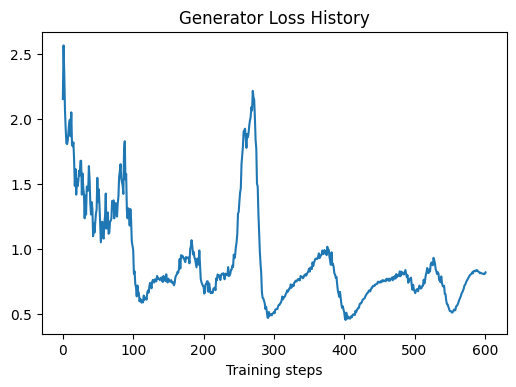

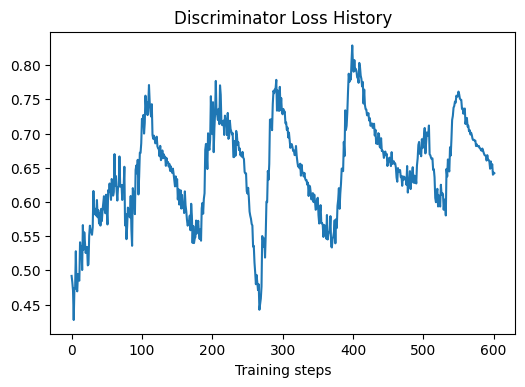

In [48]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare generated sequences between Random G and trained G

In [51]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random = generate_sequences_gumbel(1000, G0,BATCH_SIZE, T)

In [52]:
seqs_trained = generate_sequences_gumbel(1000, G, BATCH_SIZE, T)

In [54]:
tf.argmax(seqs_random, axis=2)

<tf.Tensor: shape=(1000, 21), dtype=int64, numpy=
array([[1, 2, 1, ..., 5, 2, 2],
       [1, 0, 2, ..., 0, 2, 3],
       [1, 2, 0, ..., 4, 4, 5],
       ...,
       [1, 2, 4, ..., 1, 3, 0],
       [1, 3, 5, ..., 5, 4, 0],
       [1, 1, 2, ..., 0, 3, 4]])>

In [55]:
tf.argmax(seqs_trained, axis=2)

<tf.Tensor: shape=(1000, 21), dtype=int64, numpy=
array([[1, 4, 3, ..., 2, 3, 5],
       [1, 4, 4, ..., 3, 4, 3],
       [1, 3, 4, ..., 4, 4, 3],
       ...,
       [1, 5, 2, ..., 3, 3, 3],
       [1, 5, 4, ..., 4, 3, 3],
       [1, 3, 4, ..., 4, 4, 2]])>

## Save trained G and D weights

In [57]:
if not os.path.exists(model_save_dir + '/G_run_2021-03-26'):
    os.makedirs(model_save_dir + '/G_run_2021-03-26')

G_save_path = model_save_dir + '/G_run_2021-03-26/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_2021-03-26'):
    os.makedirs(model_save_dir + '/D_run_2021-03-26')

D_save_path = model_save_dir + '/D_run_2021-03-26/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)